## Case 1 - Deterministic
## Case 2 - DRO opt w/o $\gamma$
## Case 3 - DRO opt w $\gamma$
## Case 4 - DRO opt w DRJCC
## Case 5 - DRO opt DRJCC with ESS reserve
## Case 6 - DRO opt DRJCC with ESS reserve but without revenue
### Author: Junhyeok Kim

In [1]:
# Import the library

import os
import pandas as pd
import numpy as np
import sys
import time

import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [2]:
# Define the Variables
BASE_DIR = os.getcwd()
os.chdir("../")
path = os.getcwd() 
sys.path.append(path) # 폴더 한 단계 위에서 file import 하기 위해서 sys path 설정
sys.path.append(f"{path}/src")
sys.path.append(f"{path}/src/Data_Generation")

from rts_data import generate_wind, generate_gen_dict
from aggregator import aggregator
from gurobiMILP import gurobi_MILP
from draw_fig import Single_Case_Plot

In [3]:
### Parameters
DRO_param = {'eps_joint_cvar' : 0.05}
DRO_param['theta'] = 0.5

# Vector for Bonferroni approximation
rho_vectorC = np.linspace(0, 0.0025, 26)

# Number of individual runs (number of coupled datasets in the numerical study)

IR_max = 10


# Number of maximum sample size (N)

N_max = 200

# Number of maximum out of sample data for each individual run (N') for testing
# dataset
OOS_max = 1000

# Number of sample data in training dataset (N)

N = 100;


# Total number of data 

n_total_scen = IR_max * (N_max + OOS_max)

In [4]:
# Define the Parameters

# case_dict: Generate various scenario
# res_var: Define the WT and PV as variables [True] or parameters [False]
# case:
    # case 1 : w/o uncertainty
    # case 2 : w uncertainty with DRO
    #UNIT_TIME: 1 -> 1 hour
    
case_dict = {'case':6, 'UNIT_TIME': 1, 'bid_type':'deterministic', 'n_total_scen': n_total_scen, 'N_max': N_max, 'OOS_max':OOS_max,
             'IR_max': IR_max, 'N': N, 'divide_factor': 1}
case_dict['data_scenario'] = 'random'
case_dict['wt_bound'] = 0.6
case_dict['pv_bound'] = 0.2
case_dict['rand'] = 'uniform'

case_dict['date'] = '20220911'
nTimeslot = int(24 / case_dict['UNIT_TIME'])
char_ess = {'initSOC':0.5, 'termSOC':0.5, 'minSOC':0.2, 'maxSOC':0.8, 'efficiency':0.95}


model_dict = {'nVPP':1, 'path': path, 'N_PIECE': 10, 'nTimeslot': nTimeslot, 'output_flag': 0}

# Once, set te PV, WT, SMP uncertainties identically in each time (PV: 5%, WT: 10%, SMP: 10%)
uncertainty_dict = {'pv': np.ones(nTimeslot)*0.10 , 'wt': np.ones(nTimeslot)*0.10, 'smp':np.ones(nTimeslot)*0.10}


if case_dict['case']==2:
    
    model_dict['uncertainty'] = uncertainty_dict
    case_dict['bid_type'] = 'risky'
    
elif case_dict['case'] == 1:
    
    uncertainty_dict = {'pv': np.zeros(nTimeslot), 'wt': np.zeros(nTimeslot), 'smp':np.zeros(nTimeslot)}
    model_dict['uncertainty'] = uncertainty_dict
    

In [5]:
# Set Up VPP  #Unit: kW

vpp_list = []
for i in range(model_dict['nVPP']):
    nGen_dict = {'WT':4,'PV':2, 'ESS':1, 'DG':2}
    wt_list = [1800, 2000, 1700, 2000]
    pv_list = [1000, 850, 700, 700]
    ess_list = [400]
    capacity_list = [2000]
    dg_list = [800, 700, 900]
    max_list = [wt_list, pv_list, ess_list, capacity_list, dg_list]
    
    dg_dict_list = []
    for j in range(nGen_dict['DG']):
        dg_dict_list.append(generate_gen_dict(j,dg_list[j], model_dict))
    model_dict['dg_dict_list'] = dg_dict_list
    
    agg_dict = {'name': f'cvpp{i+1}', 'code': f'xds{i+1}', 'gen':nGen_dict}
    vpp_list.append(aggregator(agg_dict, char_ess, model_dict, case_dict))
    vpp_list[i].set_der_power(max_list)
    vpp_list[i].set_smp_data(case_dict['date'])
    vpp_list[i].set_profile(case_dict['N'],0)
    vpp_list[i].set_res_cov()
    
vpp_list[0].get_res_table()

Error
'aggregator' object has no attribute 'wt_uncert'
Aggregator set_res_table method
Uncertainty does not exist
Data Generated by historical data
Data Generated by historical data
Data Generated by historical data
Data Generated by historical data
Set_Res_Cov
Set_Res_Cov


name type  number  min_power  max_power  capacity
0   WT1_cvpp1   WT       1        0.0       1800       NaN
1   WT2_cvpp1   WT       2        0.0       2000       NaN
2   WT3_cvpp1   WT       3        0.0       1700       NaN
3   WT4_cvpp1   WT       4        0.0       2000       NaN
4   PV5_cvpp1   PV       5        0.0       1000       NaN
5   PV6_cvpp1   PV       6        0.0        850       NaN
6  ESS7_cvpp1  ESS       7     -400.0        400    2000.0
7   DG8_cvpp1   DG       8       80.0        800       NaN
8   DG9_cvpp1   DG       9       70.0        700       NaN

In [6]:
# Gurobi Optimization Model
Wmax = vpp_list[0].wt_list[0].max_power 
Wmu = vpp_list[0].wt_list[0].profile_mu
#case_dict['theta'] = DRO_param['theta']* Wmu
#case_dict['theta'] = np.reshape(case_dict['theta'], -1)
case_dict['theta'] = [DRO_param['theta']] * nTimeslot
case_dict['eps'] = DRO_param['eps_joint_cvar']
case_dict['beta'] = 0.1
case_dict['alpha_max'] = 0.2
case_dict['GRID_PIECE'] = 100
case_dict['calc_rad'] = True
#case_dict['theta'] = np.array([0.05]*24)

mip_gap = 0.0001
feas_tol = 1e-4
time_limit = 600
case_dict['case'] = 6

opt_bid = gurobi_MILP('opt bid', vpp_list[0], model_dict, case_dict)

mip_gap = 0.0001
feas_tol = 1e-4
sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid.optimize(mip_gap, feas_tol)


--------------------------------------------
--------------------------------------------

Does not Cosidered alpha
Add Bid Constraint
Calculate the Radius
Calculated Theta:  0.08404099134807877
start set_dro_obj_constriants


C:\Users\HOME\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant/src\gurobiMILP.py:542: RuntimeWarning: overflow encountered in exp
  J = np.sqrt(np.absolute( (1/(2*alpha))*(1+np.log(1/100*np.sum(np.exp(alpha*test**2)))  )))
C:\Users\HOME\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:2234: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)


end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 7.8129496574401855


In [7]:
slack_dict['gamma_obj']

array([[[ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        ...,
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000]],

       [[ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        ...,
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
          0.000000],
        [ 0.000000,  0.000000,  0.000000, ...,  0.000000,  0.000000,
   

In [8]:
obj1 = obj_dict['obj1']
print(obj1)

try:
    obj2 = obj_dict['obj2']
    obj3 = obj_dict['obj3']
    print(obj2)
    print(obj3)
    
except:
    print("no obj2, obj3")

try:
    obj3_full = obj_dict['obj3_full']
except:
    pass
print(sum(obj1))
print(sum(obj2))
print(sum(obj3))

print(sum(sum(obj_dict['dg_cost'])))

print(opt_bid.m.objVal)

[ 517210.995408  506239.061816  397486.430355  374274.983826
  436186.226112  444993.192765  612394.218617  635362.310245
  625371.887114  694080.453835  663851.798054  502063.160696
  481272.708127  517817.094762  629648.575045  583590.103351
  810511.419244  790365.895393  900959.239896  783524.571158
  880155.733126  713033.144876  569918.838008  346256.313691]
[ 24171.869932  24121.445337  22203.629914  22141.439581  22149.843680
  22284.309266  25793.861065  25793.861065  24188.678130  23960.086633
  21771.659219  21771.659219  24092.871400  24185.316490  24203.805508
  24976.982629  37976.443170  41164.958382  41166.639202  41176.724121
  41166.639202  41166.639202  41166.639202  28009.181596]
[-0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000
 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000
 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000
 -0.000000 -0.000000 -0.000000]
14416568.355520215
690805.1831424187
-5.150880

In [9]:
print(P_dict['sum_dg'])

if opt_bid.is_dg_reserve:
    print(P_dict['dg_ru'])

[[ 560.000000  560.000000  320.000000  320.000000  320.000000  430.530532
   560.000000  560.000000  560.000000  560.000000  480.000000  375.347098
   480.000000  640.000000  640.000000  597.422132  634.844263  640.000000
   600.000000  640.000000  640.000000  645.253474  730.506949  648.030612]
 [ 612.961986  624.251742  364.908407  375.787757  375.787757  420.000000
   420.000000  420.000000  420.000000  488.428906  420.000000  420.000000
   490.000000  630.000000  630.000000  620.445287  630.000000  674.985047
   553.893792  687.787584  700.000000  693.982147  700.000000  700.000000]]
[[ 240.000000  240.000000  240.000000  240.000000  129.469468  110.530532
   240.000000  240.000000  240.000000  240.000000  240.000000  135.347098
   80.000000  0.000000  160.000000  202.577868  165.155737  160.000000
   200.000000  160.000000  160.000000  154.746526  69.493051  151.969388]
 [ 87.038014  75.748258  269.120650  280.000000  235.787757  280.000000
   280.000000  280.000000  211.571094  5

In [10]:
print(P_dict['essDis'])
print(P_dict['essChg'])
if opt_bid.is_ess_reserve:
    print(P_dict['RU_essdis'])
    print(P_dict['RD_esschg'])

[[ 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  118.249214
   292.428109  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000  0.000000  348.646659  0.000000
   369.328883  161.671117  0.000000  0.000000]]
[[ 0.000000  0.000000  320.394903  311.184044  0.000000  0.000000
   0.000000  0.000000  0.000000  93.385627  80.851730  400.000000
   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000  0.000000  400.000000]]
[[ 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   107.571891  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000  0.000000  51.353341  0.000000  0.000000
   0.000000  0.000000  0.000000]]
[[ 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000

In [11]:
if opt_bid.is_bid_DRCC:
    lhs_array, rhs_array, check_array, ratio = opt_bid.check_drcc_constraint()
    print("Ratio is :", ratio)
    for i in range(24):
        print(sum(check_array[i,:]))

Ratio is : 0.9683333333333334
97.0
97.0
97.0
97.0
96.0
97.0
98.0
97.0
96.0
97.0
96.0
97.0
99.0
99.0
96.0
96.0
96.0
96.0
97.0
97.0
97.0
96.0
96.0
97.0


In [12]:
from draw_fig import Single_Case_Plot

In [13]:
case_fig = Single_Case_Plot(vpp_list, opt_bid, model_dict, case_dict, path)

setPlotStyle()


save the fig at location : C:\Users\HOME\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


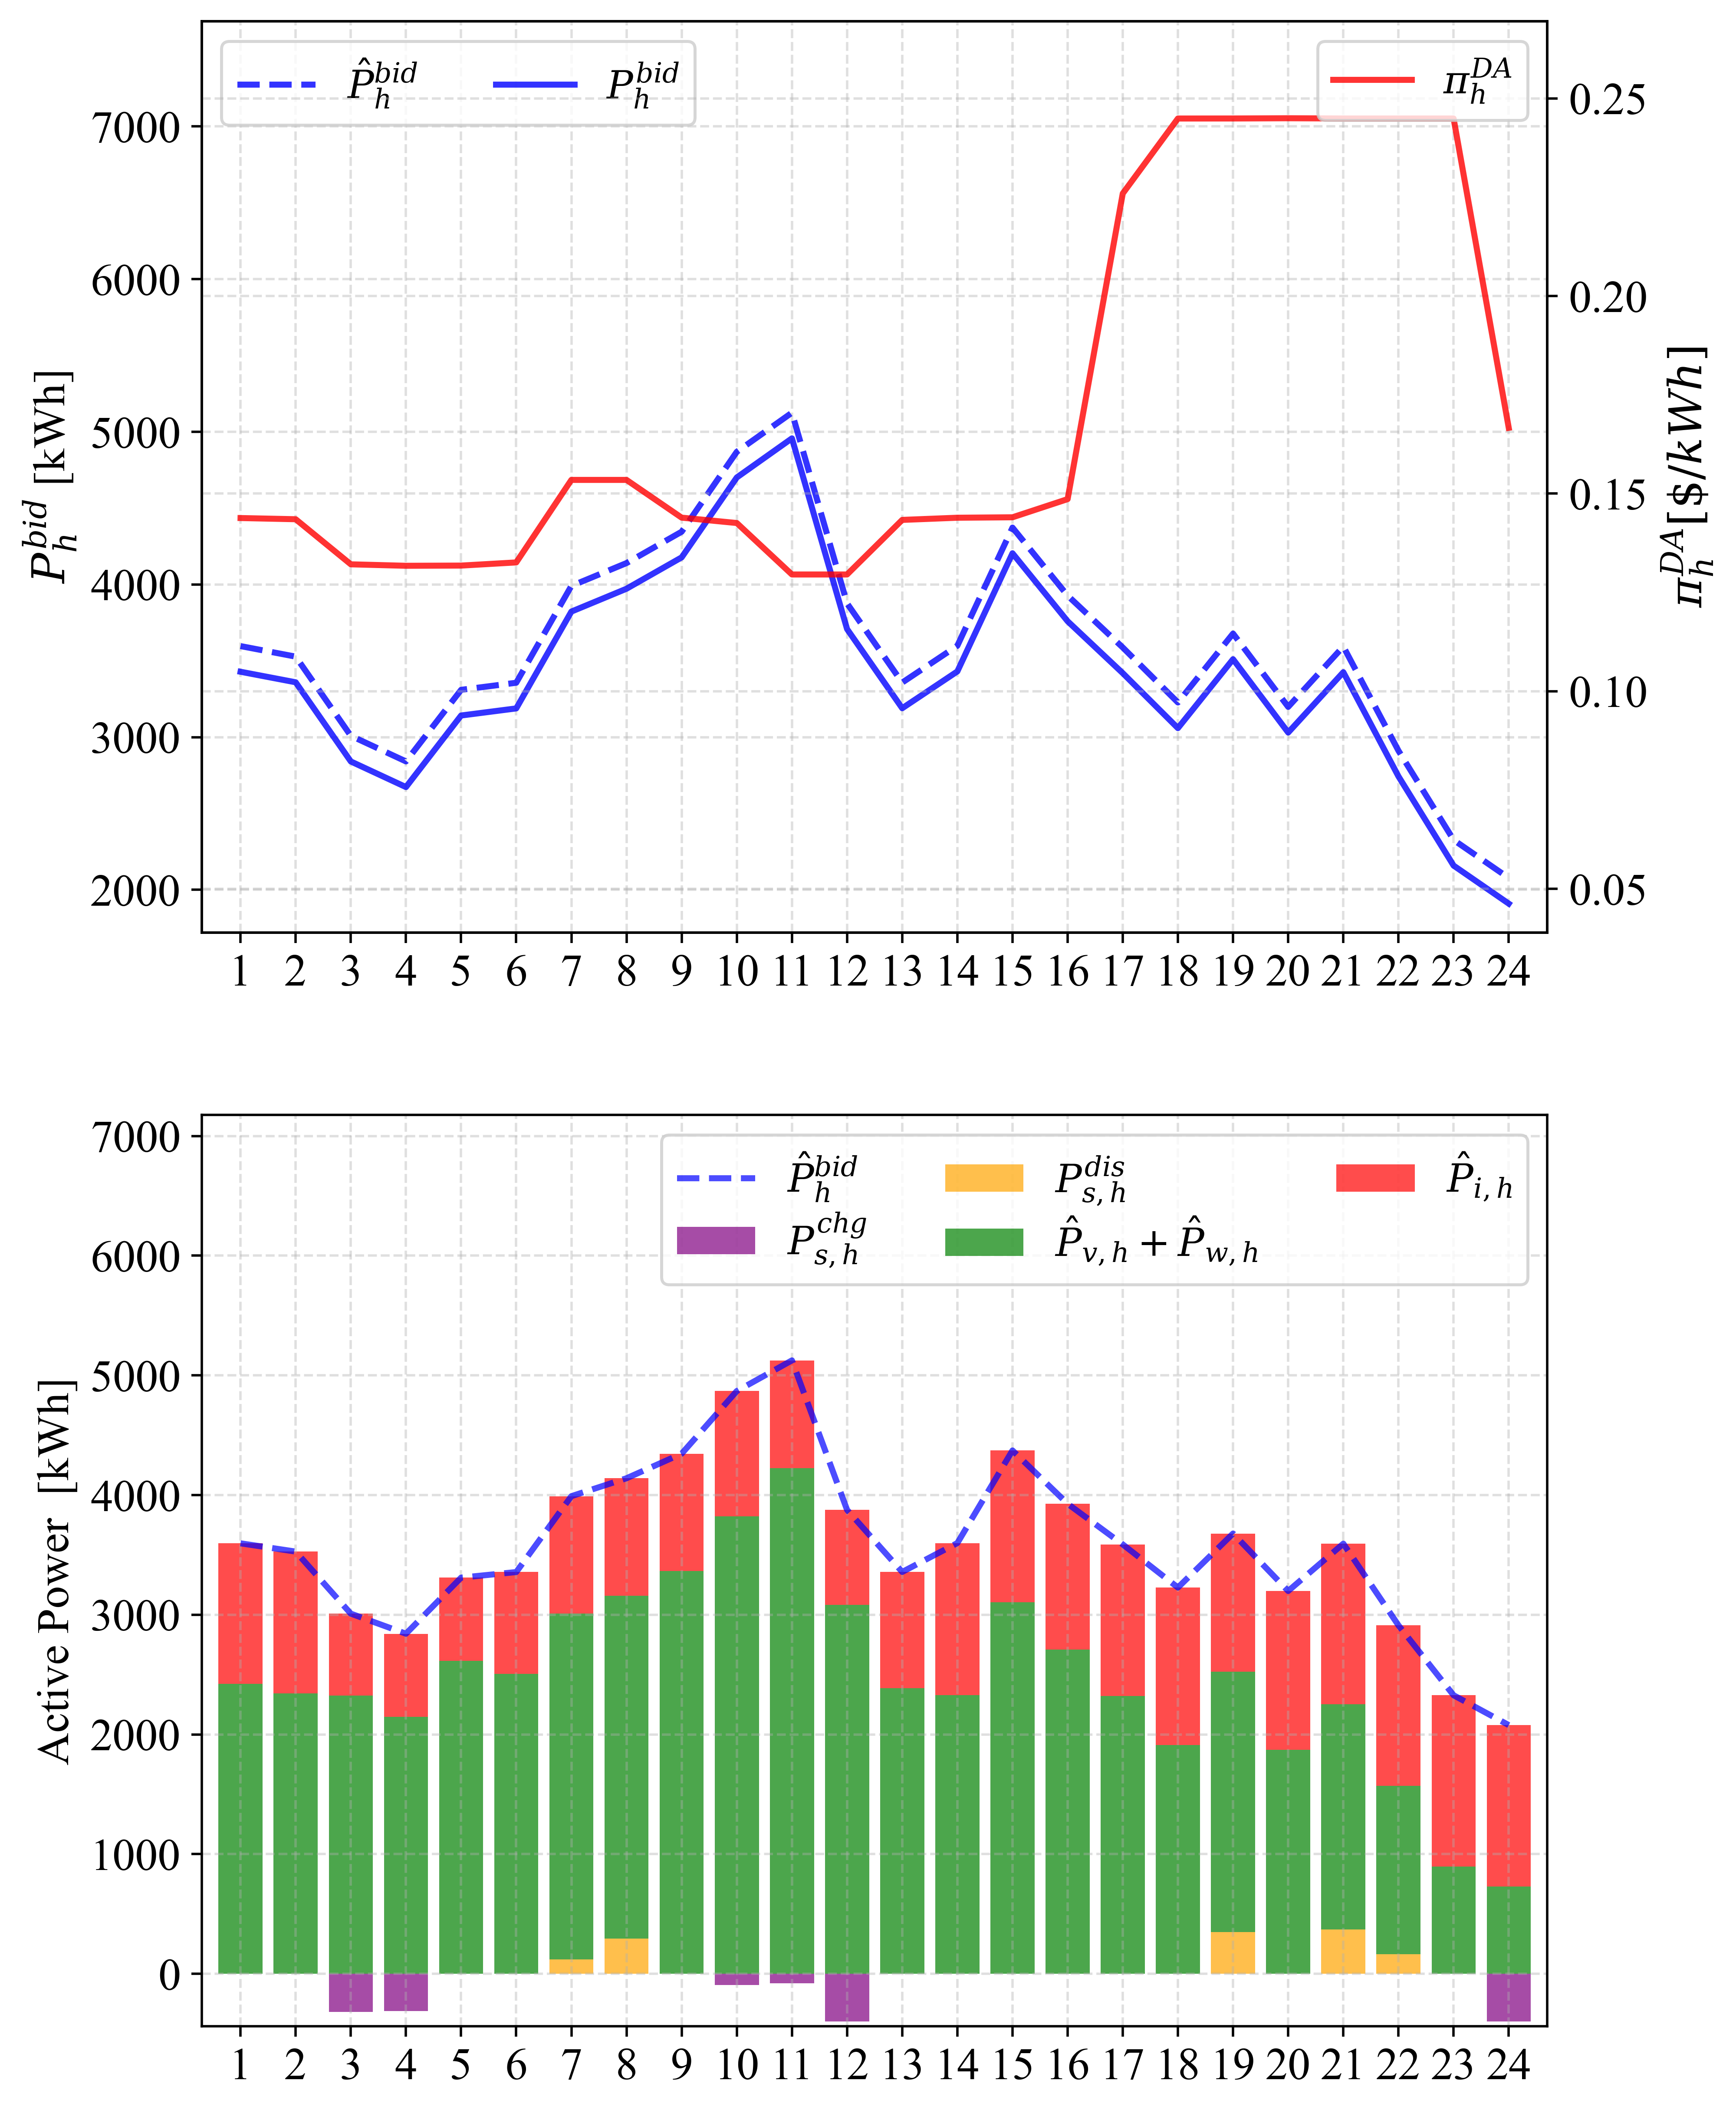

In [14]:
case_fig.make_plot(P_dict, slack_dict, save_flag=True)

In [15]:
worst_bid = np.zeros(24)

for i in range(24):
    worst_bid[i] = slack_dict['lambda_obj'][i]/case_fig.da_smp[i]
print(worst_bid)

[ 2000.000000  2000.000000  2000.000000  2000.000000  2000.000000
  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000
  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000
  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000
  2000.000000  2000.000000  2000.000000  2000.000000]


save the fig at location : C:\Users\HOME\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


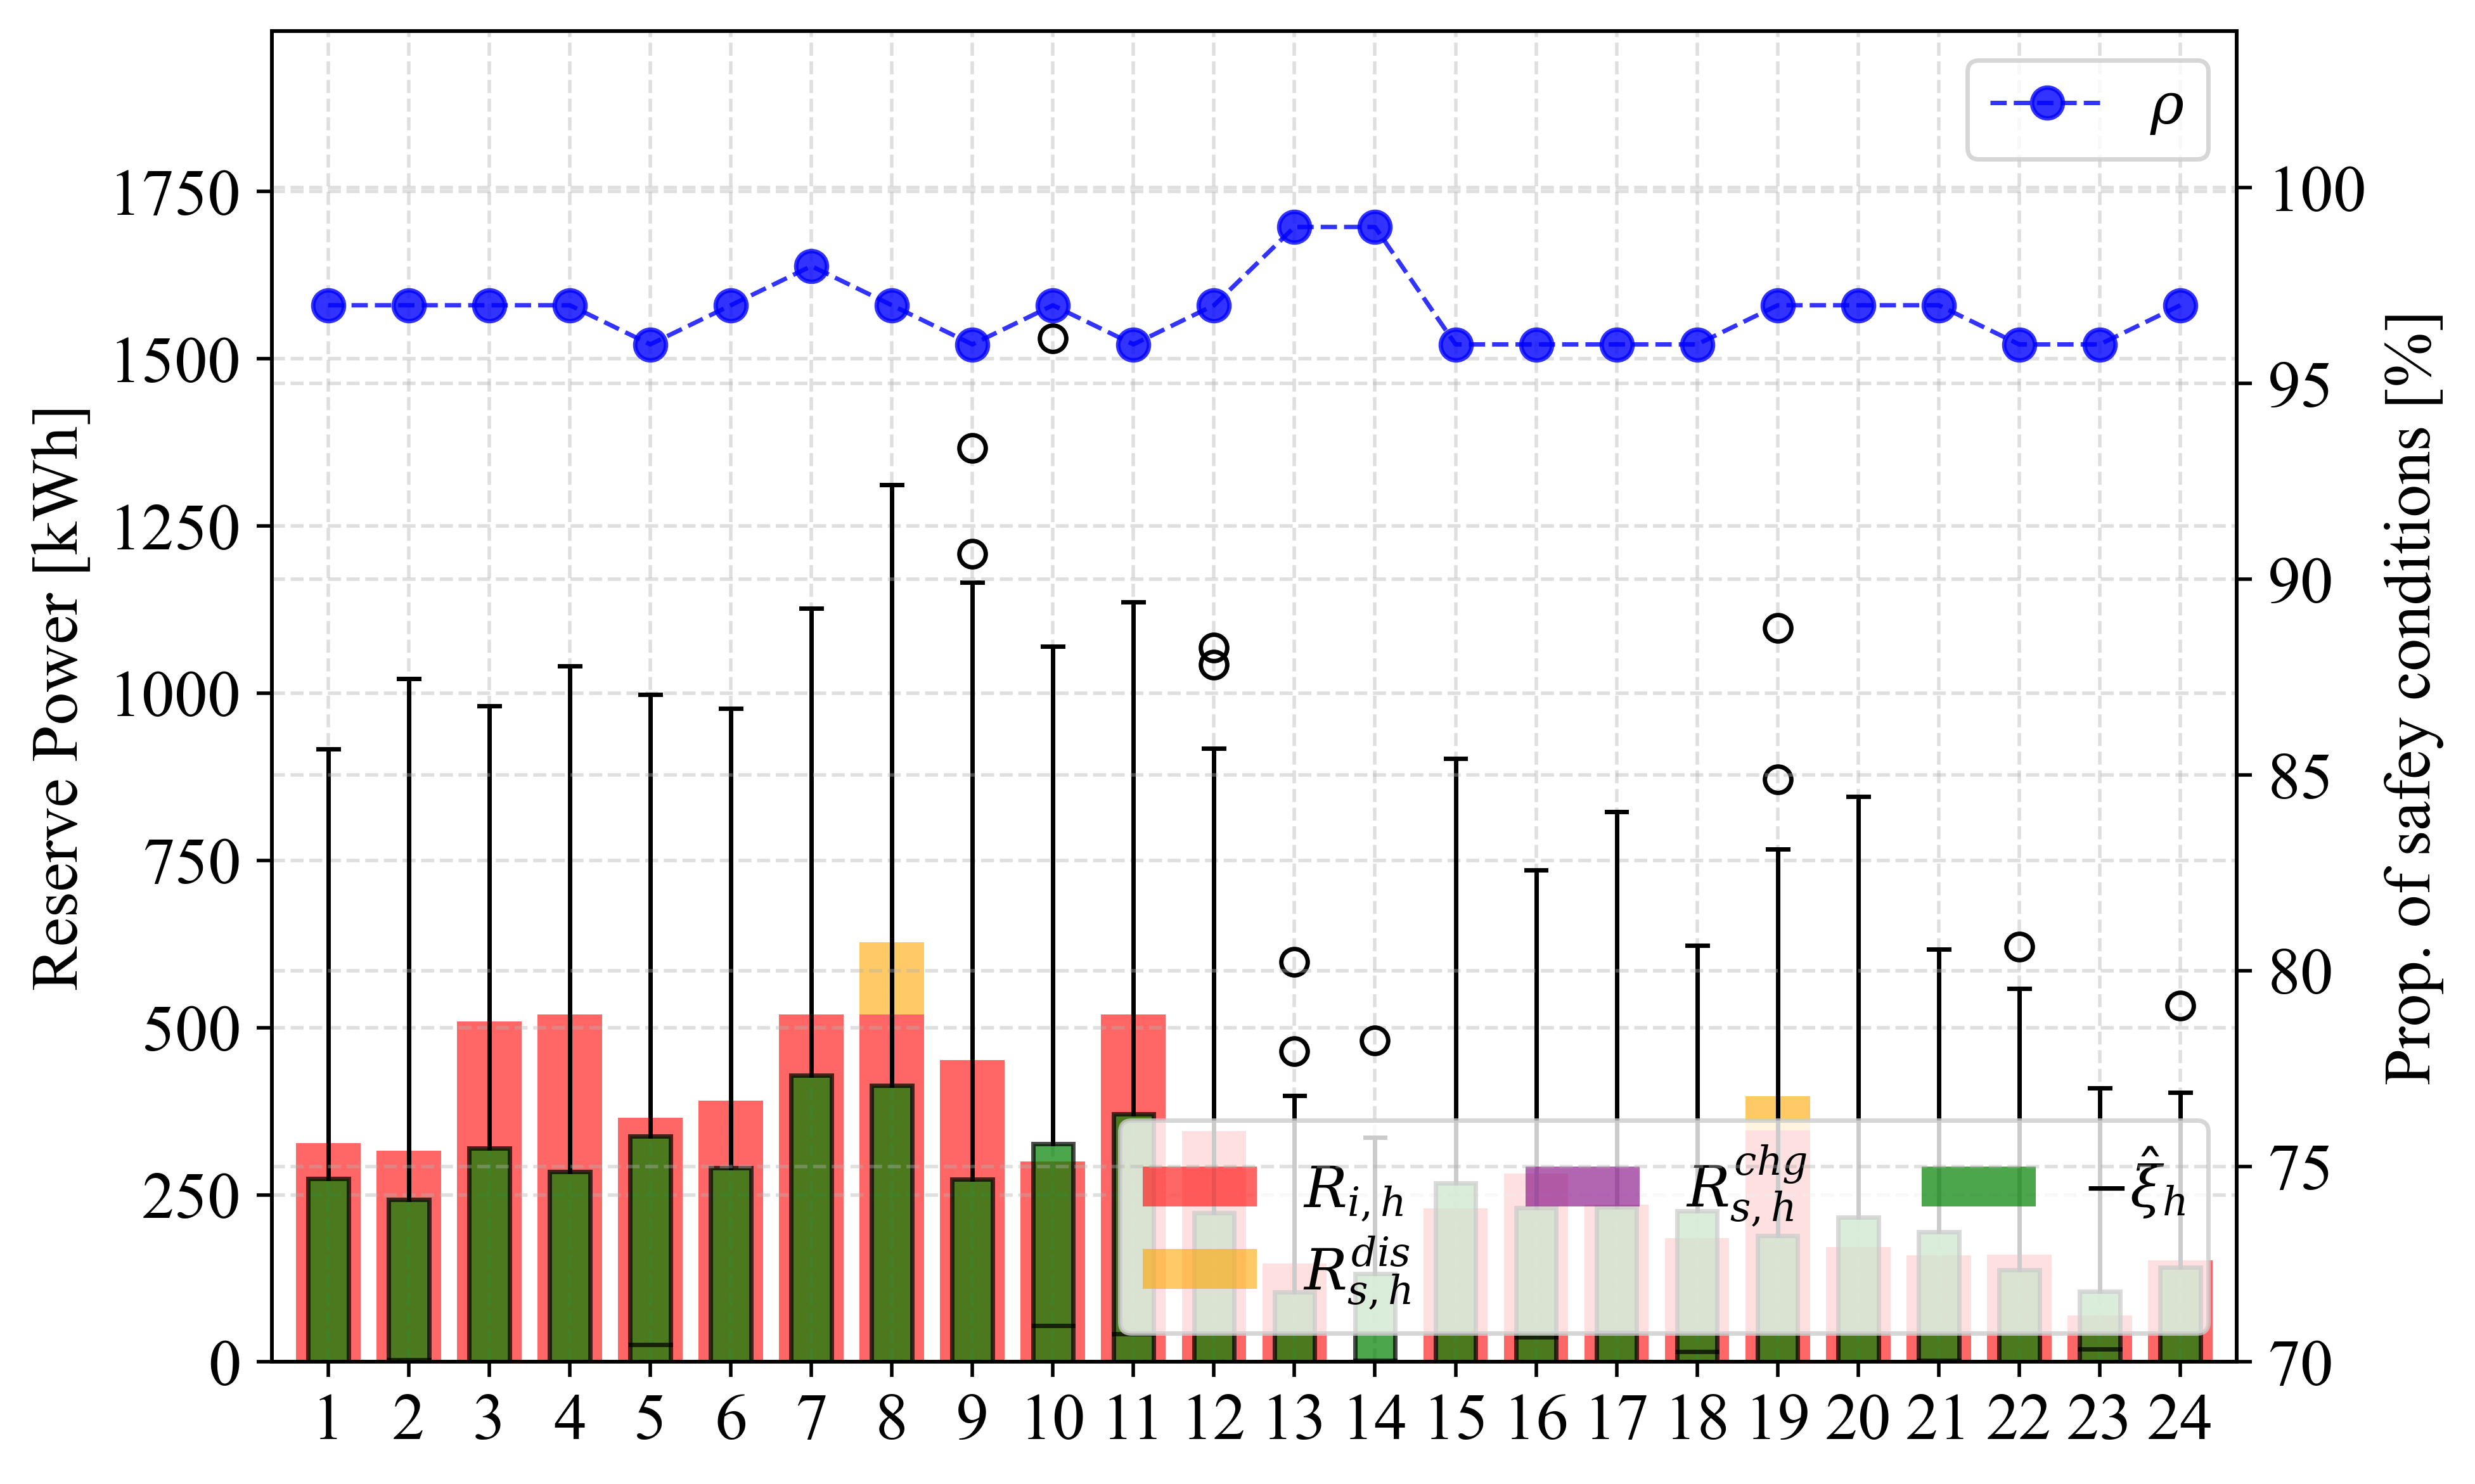

In [16]:
if opt_bid.is_ess_reserve or opt_bid.is_dg_reserve:
    case_fig.make_reserve_plot(P_dict, save_flag=True)

In [17]:
case_dict['case'] = 1


opt_bid_base = gurobi_MILP('opt bid_base', vpp_list[0], model_dict, case_dict)

mip_gap = 0.0001
feas_tol = 1e-4
sol_base, obj_dict_base, P_dict_base, U_dict_base, slack_dict_base = opt_bid_base.optimize(mip_gap, feas_tol)


case 1 add Variables
gurobi_MILP add Variables
No Uncertainty Sets in this case

Does not Cosidered alpha
Add Bid Constraint
start set_base_objectives
No Considered Any Case at base_Objectives
No obj_sum_without_bid before this
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 0.019998788833618164


In [18]:

all_obj_dicts = [[None] * 10 for _ in range(10)]
all_P_dicts = [[None] * 10 for _ in range(10)]
all_U_dicts = [[None] * 10 for _ in range(10)]
all_objVal = [[None] * 10 for _ in range(10)]
all_solve_time = [[None] * 10 for _ in range(10)]
all_reliable = [[None] * 10 for _ in range(10)]
all_reliable_array = [[None] * 10 for _ in range(10)]

case_dict['case'] = 6
case_dict['calc_rad'] = False
start_time = time.time()
for i in range(10):
    for j in range(10):
        print("*"*30)
        print("iterion i,j :", i,j)
        print("iterion i,j :", i,j)
        print("iterion i,j :", i,j)
        print("*"*30)
        DRO_param['eps_joint_cvar'] = i*0.01 + 0.01
        DRO_param['theta'] = j*0.01 + 0.01
        
        
        # Gurobi Optimization Model
        case_dict['theta'] = [DRO_param['theta']] * nTimeslot
        case_dict['eps'] = DRO_param['eps_joint_cvar']
        #case_dict['theta'] = np.array([0.05]*24)

        opt_bid = gurobi_MILP(f'opt bid{i}_{j}', vpp_list[0], model_dict, case_dict)
        sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid.optimize(mip_gap, feas_tol)
        print("opt_bid.m.objVal :", opt_bid.m.objVal)
        all_obj_dicts[i][j] = obj_dict
        all_P_dicts[i][j] = P_dict
        all_U_dicts[i][j] = U_dict
        all_objVal[i][j] = opt_bid.m.objVal
        all_solve_time[i][j] = opt_bid.opt_solve_time
        if opt_bid.is_bid_DRCC:
            lhs_array, rhs_array, check_array, ratio = opt_bid.check_drcc_constraint()
            all_reliable_array[i][j] = check_array
            all_reliable[i][j] = ratio * 100
        else:
            print("No is_bid_DRCC")
            
end_time = time.time()
total_solution_time = end_time - start_time

******************************
iterion i,j : 0 0
iterion i,j : 0 0
iterion i,j : 0 0
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 0.1600019931793213
opt_bid.m.objVal : 9979210.488645816
******************************
iterion i,j : 0 1
iterion i,j : 0 1
iterion i,j : 0 1
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 0.14500069618225098
opt_bid.m.

start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 2.179971218109131
opt_bid.m.objVal : 9695141.637355726
******************************
iterion i,j : 1 7
iterion i,j : 1 7
iterion i,j : 1 7
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 2.3349733352661133
opt_bid.m.objVal : 9606037.031281099
******************************
iterion i,j : 1 8
iterion i,j : 1 8
iterion i,j : 1 8
******************************
Does not Cosidered alpha
Add Bid Constraint
start

iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 3.3170006275177
opt_bid.m.objVal : 10436502.013554513
******************************
iterion i,j : 3 3
iterion i,j : 3 3
iterion i,j : 3 3
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 4.1730029582977295
opt_bid.m.objVal : 10349692.470586276
******************************
iterion i,j : 3 4
iterion i,j : 3 4
iterion i,j : 3 4
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj

iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 6.007295846939087
opt_bid.m.objVal : 9982473.38884133
******************************
iterion i,j : 4 9
iterion i,j : 4 9
iterion i,j : 4 9
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 4.404353857040405
opt_bid.m.objVal : 9896260.800872244
******************************
iterion i,j : 5 0
iterion i,j : 5 0
iterion i,j : 5 0
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_c

iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 7.29200005531311
opt_bid.m.objVal : 10376197.388734598
******************************
iterion i,j : 6 5
iterion i,j : 6 5
iterion i,j : 6 5
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 8.52531385421753
opt_bid.m.objVal : 10291477.869914874
******************************
iterion i,j : 6 6
iterion i,j : 6 6
iterion i,j : 6 6
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
i

iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 14.201974630355835
opt_bid.m.objVal : 10756093.007928846
******************************
iterion i,j : 8 1
iterion i,j : 8 1
iterion i,j : 8 1
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 7.377999782562256
opt_bid.m.objVal : 10671431.416902695
******************************
iterion i,j : 8 2
iterion i,j : 8 2
iterion i,j : 8 2
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjc

iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 13.079000473022461
opt_bid.m.objVal : 10262595.371406537
******************************
iterion i,j : 9 7
iterion i,j : 9 7
iterion i,j : 9 7
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Optimal Solution:
Optimization Duration Time: 13.312999486923218
opt_bid.m.objVal : 10177914.86280173
******************************
iterion i,j : 9 8
iterion i,j : 9 8
iterion i,j : 9 8
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
start drjc

In [19]:
total_solution_time

1156.4457683563232

In [20]:
df = pd.DataFrame(all_reliable)
df1 = pd.DataFrame(all_solve_time)
df2 = pd.DataFrame(all_objVal)

# Specify the Excel file path where you want to export the data
excel_file = f'{path}/result/output_reliable.xlsx'
excel_file1 = f'{path}/result/output_solve_time.xlsx'
excel_file2 = f'{path}/result/output_objVal.xlsx'
# Use the to_excel method to export the DataFrame to an Excel file
df.to_excel(excel_file, index=False)
df.to_excel(excel_file1, index=False)
df.to_excel(excel_file2, index=False)

In [21]:
df1 = pd.DataFrame(all_reliable,all_solve_time)

In [22]:
df1

0  \
0.160002 2.112000 3.040973 4.676001 5.724034 6.425003 8.041975 10.883000 14.201975 10.738999  100.000000   
0.145001 1.930001 3.327000 4.528997 5.325000 7.169000 7.294975 8.069000  7.378000  9.478998    99.041667   
0.143975 2.098971 2.948001 3.317001 5.311040 5.694973 8.886999 8.372000  7.983505  9.218971    98.041667   
0.149976 1.966974 3.345999 4.173003 5.355974 6.345000 9.236517 8.815001  8.800999  11.343081   97.041667   
0.151973 2.177999 2.066975 4.212000 6.359998 6.279999 7.292000 10.771001 7.736031  11.019026   96.125000   
0.163000 2.065001 2.643973 5.041998 5.234938 6.072970 8.525314 8.586974  9.894000  10.289973   95.291667   
0.152974 2.179971 2.940974 3.706998 4.832508 5.733974 9.093554 8.709974  9.415026  13.079000   94.291667   
0.145998 2.334973 2.995001 3.908577 6.865523 4.952027 7.983541 8.468027  8.938027  13.312999   93.333333   
0.163001 2.069391 3.005100 4.042126 6.007296 5.538000 7.482976 8.120001  10.123000 10.139996   92.416667   
0.146021 1.634972 3.098996 3.702974 4.404354 6.341001 7.669514 9.659999  10.889975 13.481000   91.625000   

                                                                                                       1  \
0.160002 2.112000 3.040973 4.676001 5.724034 6.425003 8.041975 10.883000 14.201975 10.738999  100.000000   
0.145001 1.930001 3.327000 4.528997 5.325000 7.169000 7.294975 8.069000  7.378000  9.478998    99.083333   
0.143975 2.098971 2.948001 3.317001 5.311040 5.694973 8.886999 8.372000  7.983505  9.218971    98.083333   
0.149976 1.966974 3.345999 4.173003 5.355974 6.345000 9.236517 8.815001  8.800999  11.343081   97.041667   
0.151973 2.177999 2.066975 4.212000 6.359998 6.279999 7.292000 10.771001 7.736031  11.019026   96.166667   
0.163000 2.065001 2.643973 5.041998 5.234938 6.072970 8.525314 8.586974  9.894000  10.289973   95.416667   
0.152974 2.179971 2.940974 3.706998 4.832508 5.733974 9.093554 8.709974  9.415026  13.079000   94.333333   
0.145998 2.334973 2.995001 3.908577 6.865523 4.952027 7.983541 8.468027  8.938027  13.312999   93.416667   
0.163001 2.069391 3.005100 4.042126 6.007296 5.538000 7.482976 8.120001  10.123000 10.139996   92.458333   
0.146021 1.634972 3.098996 3.702974 4.404354 6.341001 7.669514 9.659999  10.889975 13.481000   91.541667   

                                                                                                       2  \
0.160002 2.112000 3.040973 4.676001 5.724034 6.425003 8.041975 10.883000 14.201975 10.738999  100.000000   
0.145001 1.930001 3.327000 4.528997 5.325000 7.169000 7.294975 8.069000  7.378000  9.478998    99.125000   
0.143975 2.098971 2.948001 3.317001 5.311040 5.694973 8.886999 8.372000  7.983505  9.218971    98.125000   
0.149976 1.966974 3.345999 4.173003 5.355974 6.345000 9.236517 8.815001  8.800999  11.343081   97.083333   
0.151973 2.177999 2.066975 4.212000 6.359998 6.279999 7.292000 10.771001 7.736031  11.019026   96.166667   
0.163000 2.065001 2.643973 5.041998 5.234938 6.072970 8.525314 8.586974  9.894000  10.289973   95.458333   
0.152974 2.179971 2.940974 3.706998 4.832508 5.733974 9.093554 8.709974  9.415026  13.079000   94.375000   
0.145998 2.334973 2.995001 3.908577 6.865523 4.952027 7.983541 8.468027  8.938027  13.312999   93.541667   
0.163001 2.069391 3.005100 4.042126 6.007296 5.538000 7.482976 8.120001  10.123000 10.139996   92.500000   
0.146021 1.634972 3.098996 3.702974 4.404354 6.341001 7.669514 9.659999  10.889975 13.481000   91.625000   

                                                                                                       3  \
0.160002 2.112000 3.040973 4.676001 5.724034 6.425003 8.041975 10.883000 14.201975 10.738999  100.000000   
0.145001 1.930001 3.327000 4.528997 5.325000 7.169000 7.294975 8.069000  7.378000  9.478998    99.166667   
0.143975 2.098971 2.948001 3.317001 5.311040 5.694973 8.886999 8.372000  7.983505  9.218971    98.250000   
0.149976 1.966974 3.345999 4.173003 5.355974 6.345000 9.236517 8.815001  8.800999  11.343081   97.208333

In [23]:
df2

0             1             2             3             4  \
0  9.979210e+06  9.889209e+06  9.799172e+06  9.709134e+06  9.619096e+06   
1  1.022978e+07  1.014067e+07  1.005157e+07  9.962457e+06  9.873351e+06   
2  1.051372e+07  1.042519e+07  1.033665e+07  1.024811e+07  1.015955e+07   
3  1.060989e+07  1.052321e+07  1.043650e+07  1.034969e+07  1.026282e+07   
4  1.067046e+07  1.058475e+07  1.049881e+07  1.041283e+07  1.032684e+07   
5  1.069776e+07  1.061269e+07  1.052767e+07  1.044274e+07  1.035783e+07   
6  1.071510e+07  1.063035e+07  1.054565e+07  1.046092e+07  1.037620e+07   
7  1.073698e+07  1.065228e+07  1.052217e+07  1.048296e+07  1.039828e+07   
8  1.075609e+07  1.067143e+07  1.058677e+07  1.050209e+07  1.041741e+07   
9  1.076950e+07  1.068535e+07  1.060091e+07  1.051654e+07  1.043187e+07   

              5             6             7             8             9  
0  9.529058e+06  9.439020e+06  9.348905e+06  9.258332e+06  9.167698e+06  
1  9.784247e+06  9.695142e+06  9.606037e+06  9.516820e+06  9.427869e+06  
2  1.007091e+07  9.982367e+06  9.893874e+06  9.805270e+06  9.716341e+06  
3  1.017594e+07  1.008890e+07  1.000172e+07  9.914462e+06  9.827211e+06  
4  1.024086e+07  1.015488e+07  1.006870e+07  9.982473e+06  9.896261e+06  
5  1.027296e+07  1.018809e+07  1.010320e+07  1.001832e+07  9.933380e+06  
6  1.029148e+07  1.020670e+07  1.012203e+07  1.003732e+07  9.952694e+06  
7  1.031351e+07  1.022892e+07  1.014424e+07  1.005927e+07  9.974855e+06  
8  1.033273e+07  1.024803e+07  1.016336e+07  1.007868e+07  9.994006e+06  
9  1.034721e+07  1.026260e+07  1.017791e+07  1.009331e+07  1.000888e+07

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


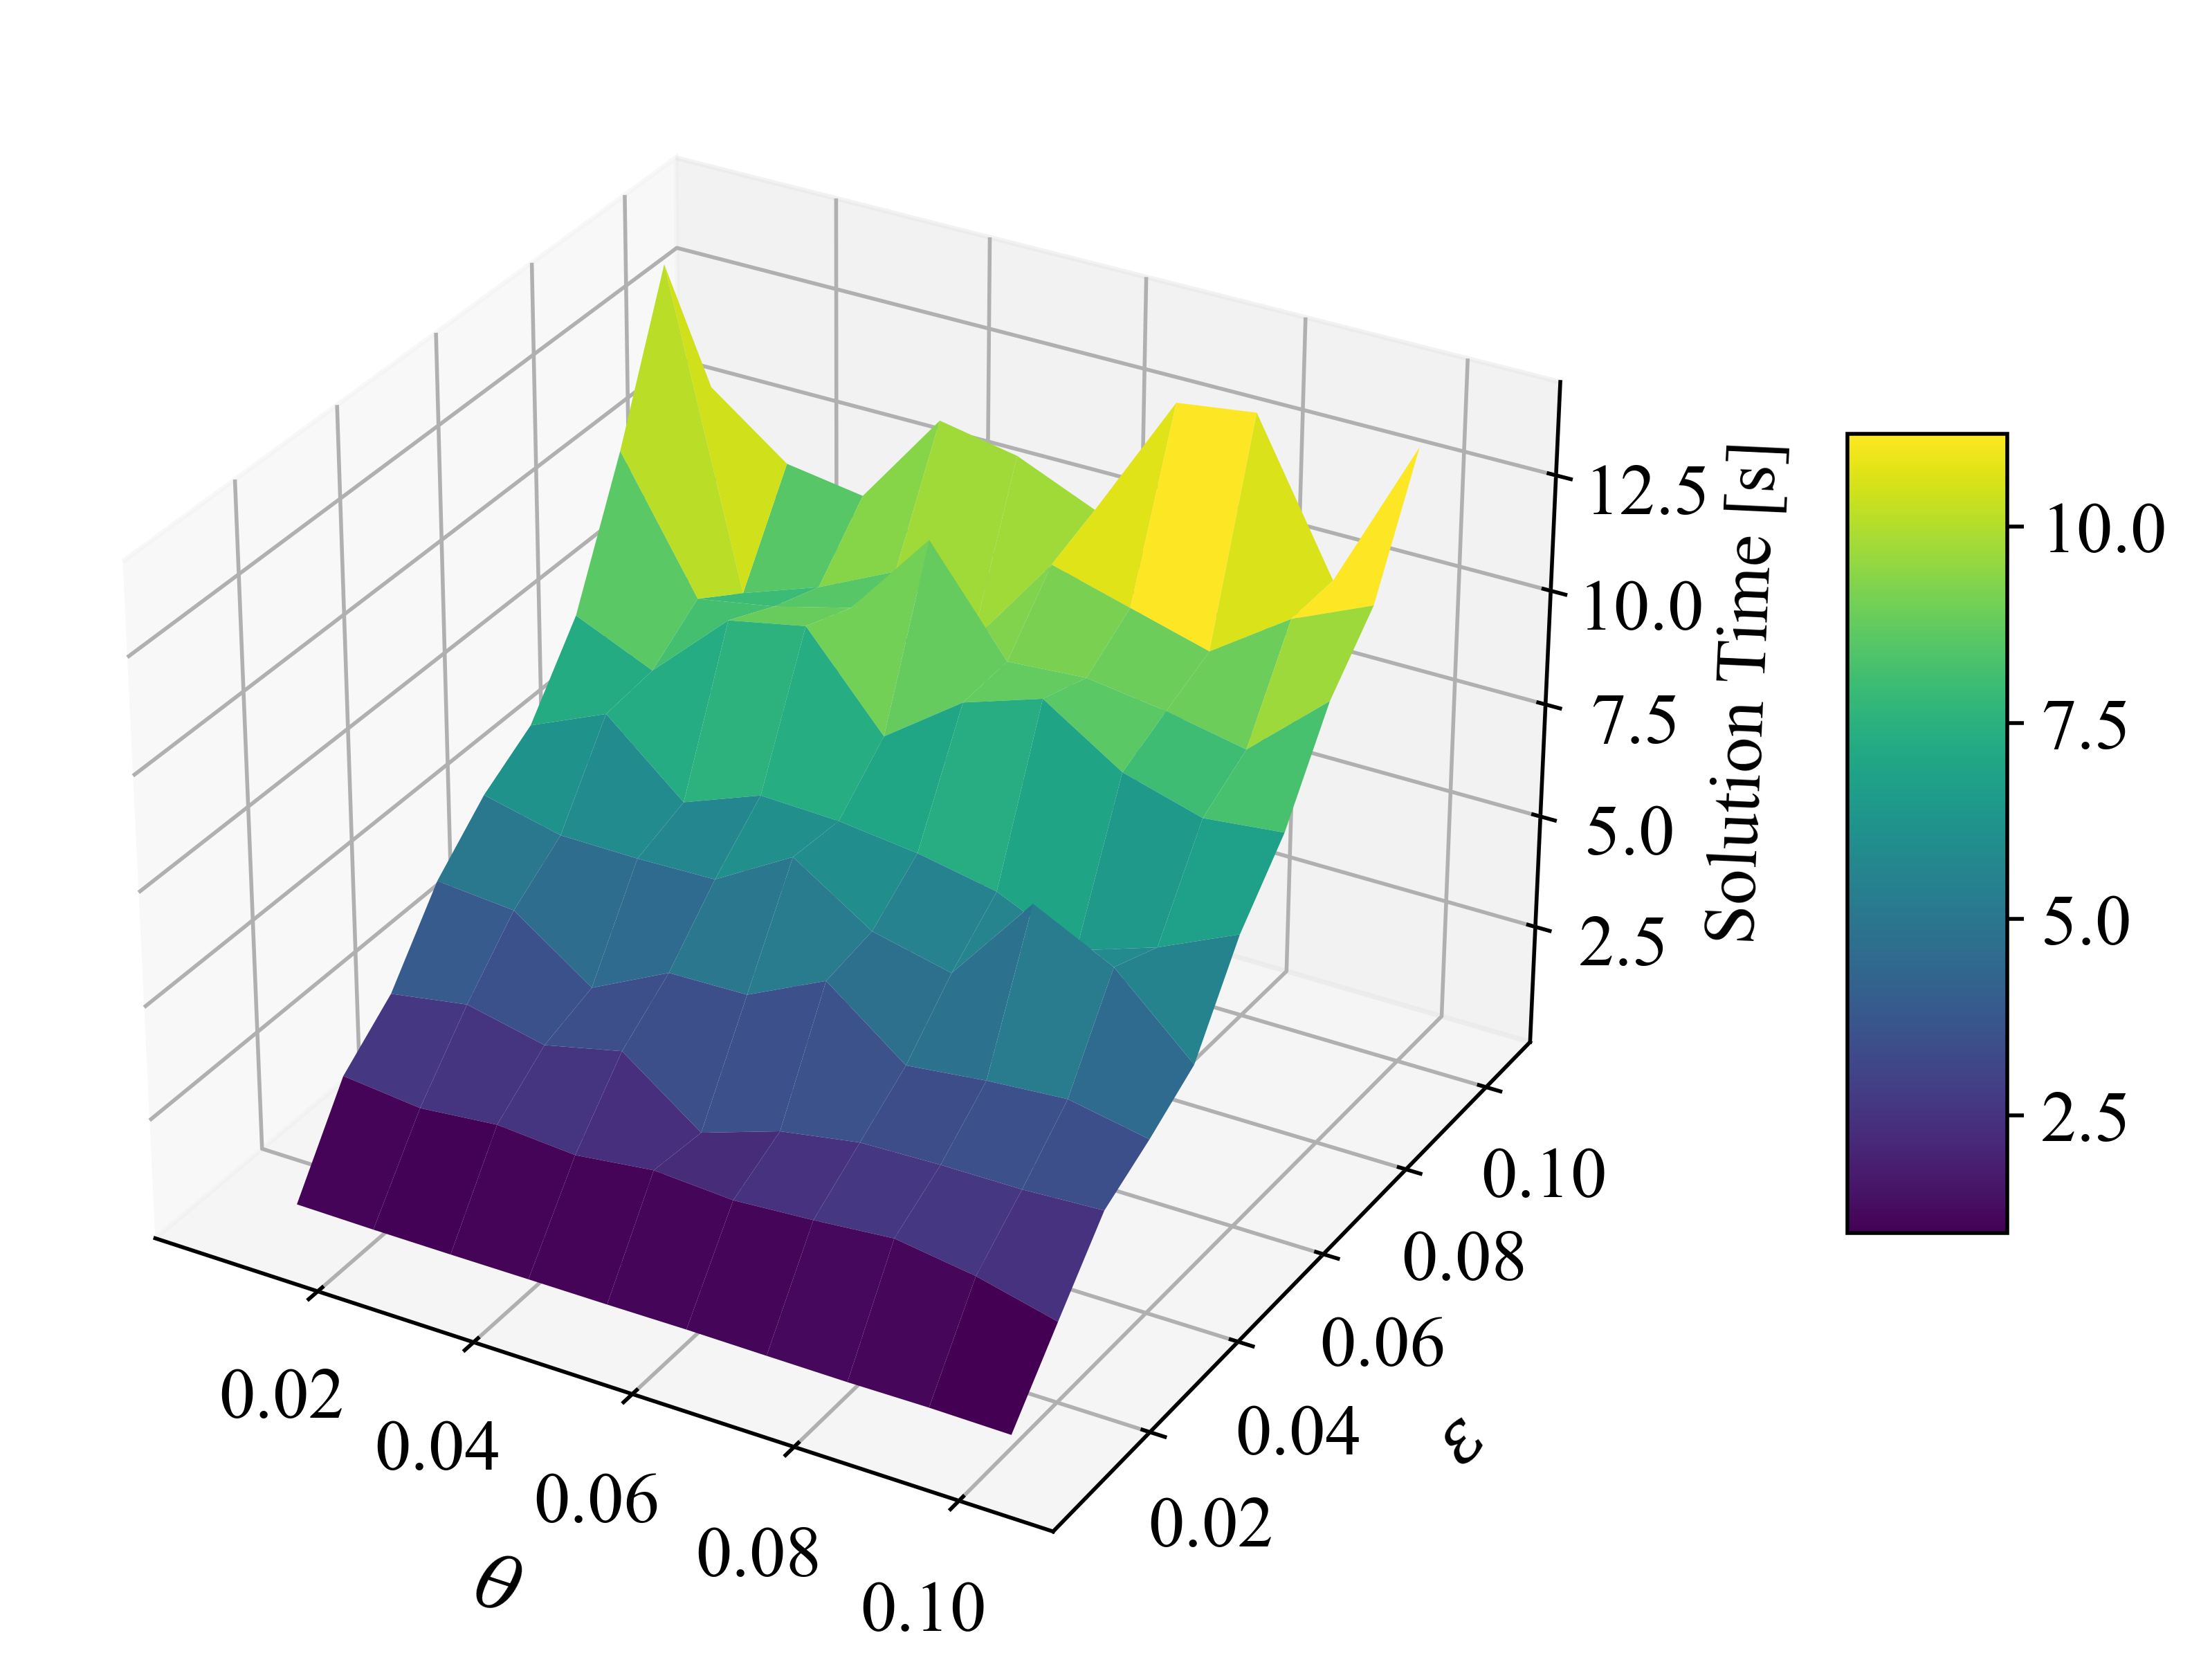

In [24]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.
x_label = r'$\theta$'
y_label = r'$\epsilon$'
z_label = 'Solution Time [s]'
title = r"Solution Time  via ($\theta$, $\epsilon$)"
file_name = 'Solution Time'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
data = all_solve_time  # 10x10 matrix as seen in the image
# case_fig.path = "C:/Users/user/OneDrive/1. CODE/IGDT-DRO-optimal-bidding-of-virtual-power-plant"
case_fig.make_3d_plot(data, label_name, save_flag = True)

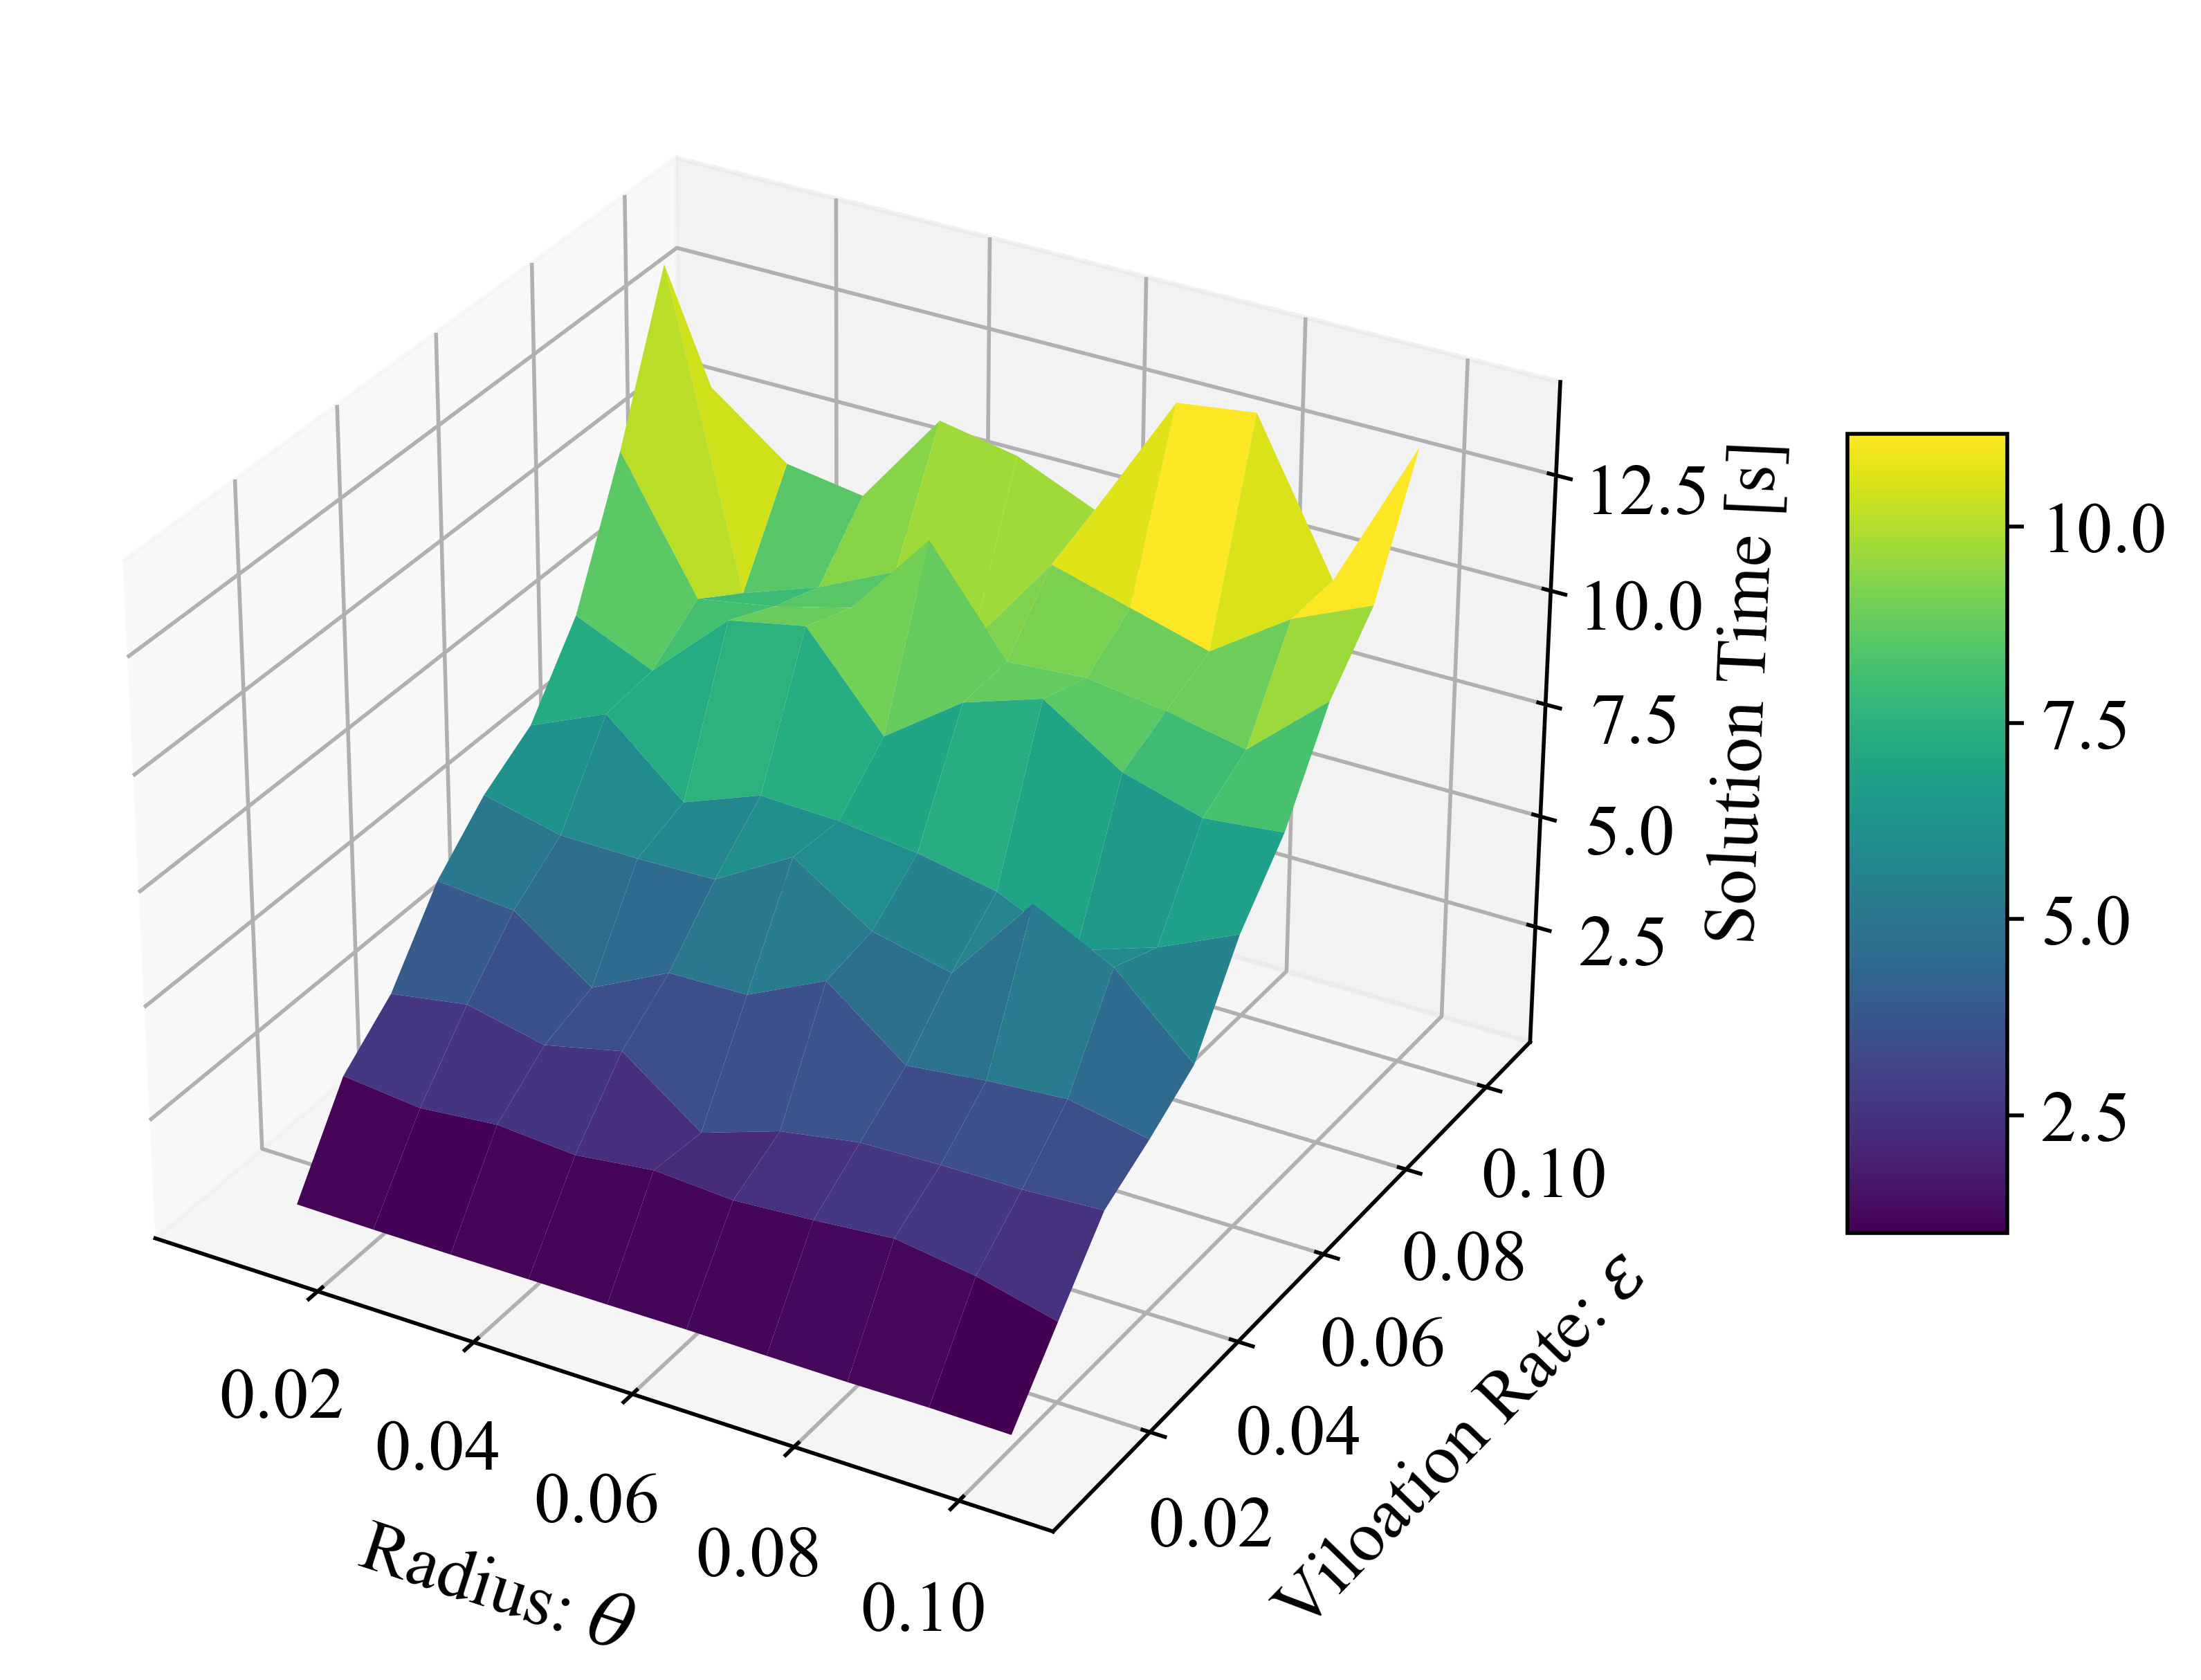

In [25]:
x_label = r'Radius: $\theta$'
y_label = r'Viloation Rate: $\epsilon$'
z_label = 'Solution Time [s]'
title = r"Solution Time  via $\theta$, $\epsilon$"
file_name = 'Soltuion Time'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
data = all_solve_time  # 10x10 matrix as seen in the image

x_label = label_name[0]
y_label = label_name[1]
z_label = label_name[2]
title = label_name[3]
file_name = label_name[4]

df = pd.DataFrame(data)

# Initialize a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create coordinate arrays for the dataframe values
X = np.arange(df.shape[1])*0.01 + 0.01
Y = np.arange(df.shape[0])*0.01 + 0.01
X, Y = np.meshgrid(X, Y)
Z = df.values

# Plotting the 3D surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.1)

# Set labels
ax.set_xlabel(x_label, labelpad=10) # labelpad 값을 조정하여 레이블과 눈금 사이의 거리를 조절할 수 있습니다.
ax.set_ylabel(y_label, labelpad=10) # labelpad 값을 조정하여 레이블과 눈금 사이의 거리를 조절할 수 있습니다.
ax.set_zlabel(z_label, labelpad=5)

# Show the plot
plt.savefig("C:/Users/user/OneDrive/1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant/fig/test.png", dpi = 500, bbox_inches='tight')
plt.show()


save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


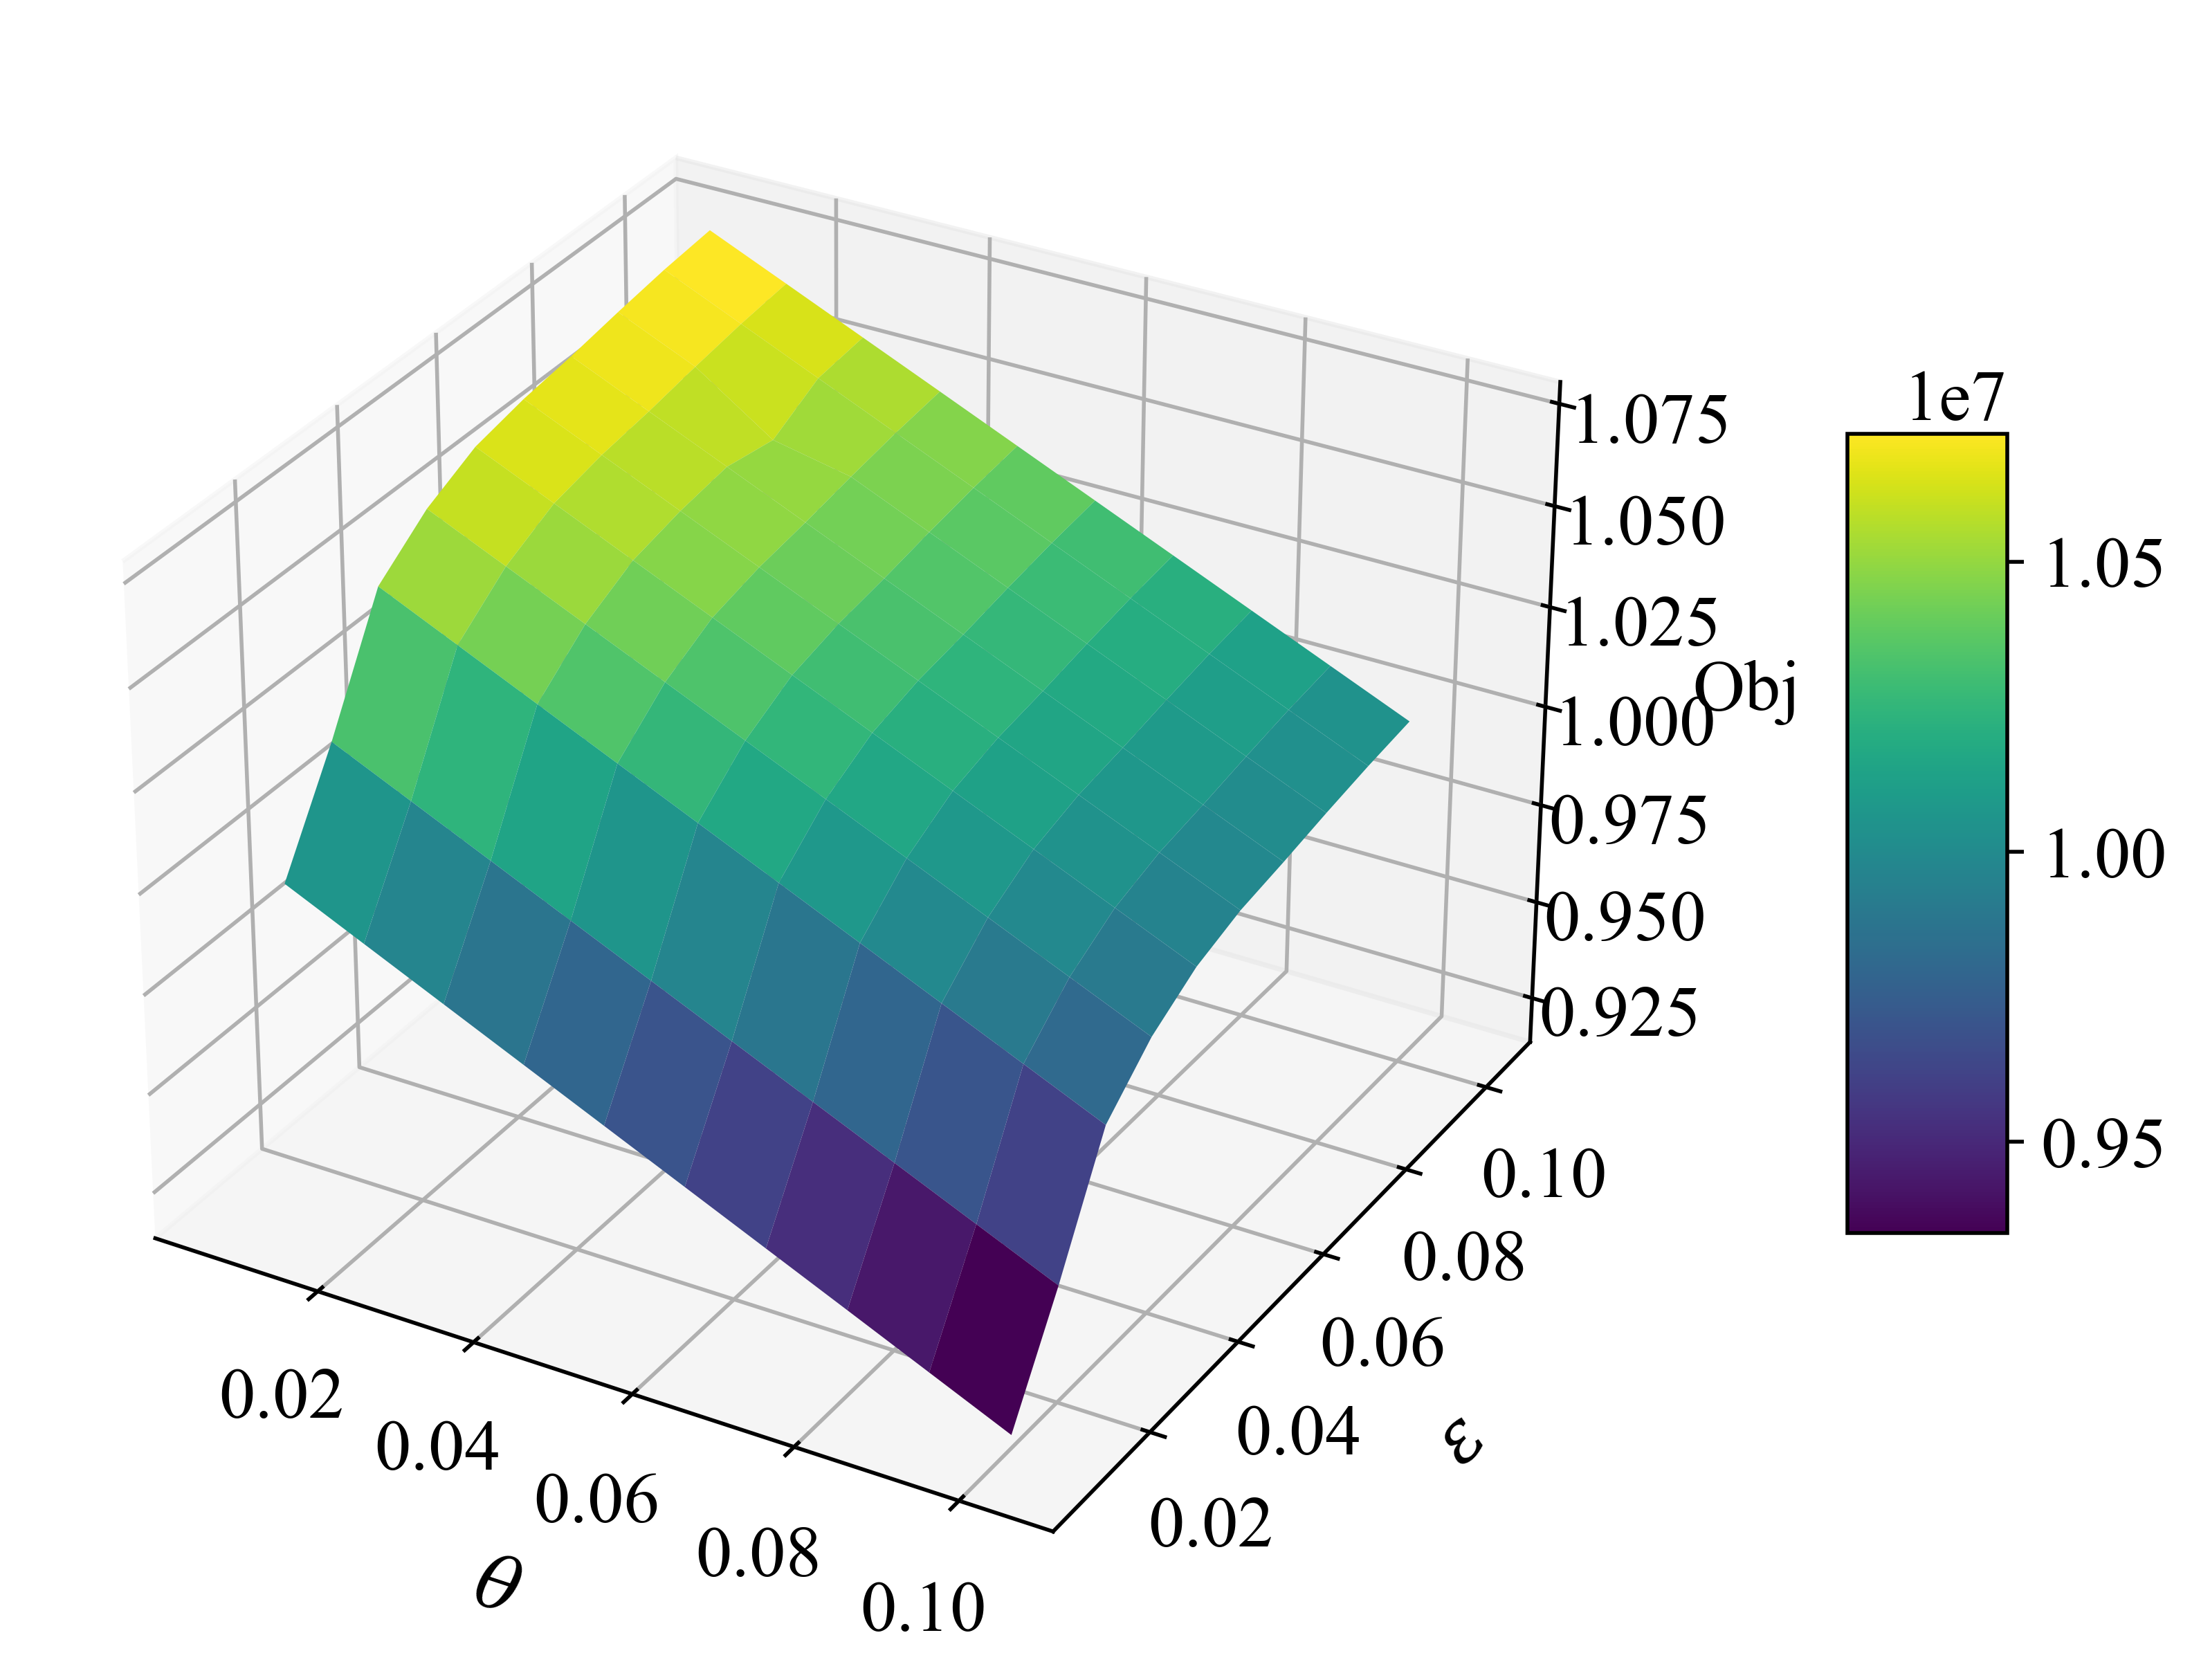

In [26]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.

# Create a sample dataframe
data = all_objVal  # 10x10 matrix as seen in the image

x_label = r'$\theta$'
y_label = r'$\epsilon$'
z_label = 'Obj'
title = r"Objective Value via $\theta$, $\epsilon$"
file_name = 'wdrcc_objective_value'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
case_fig.make_3d_plot(data, label_name, save_flag = True)

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


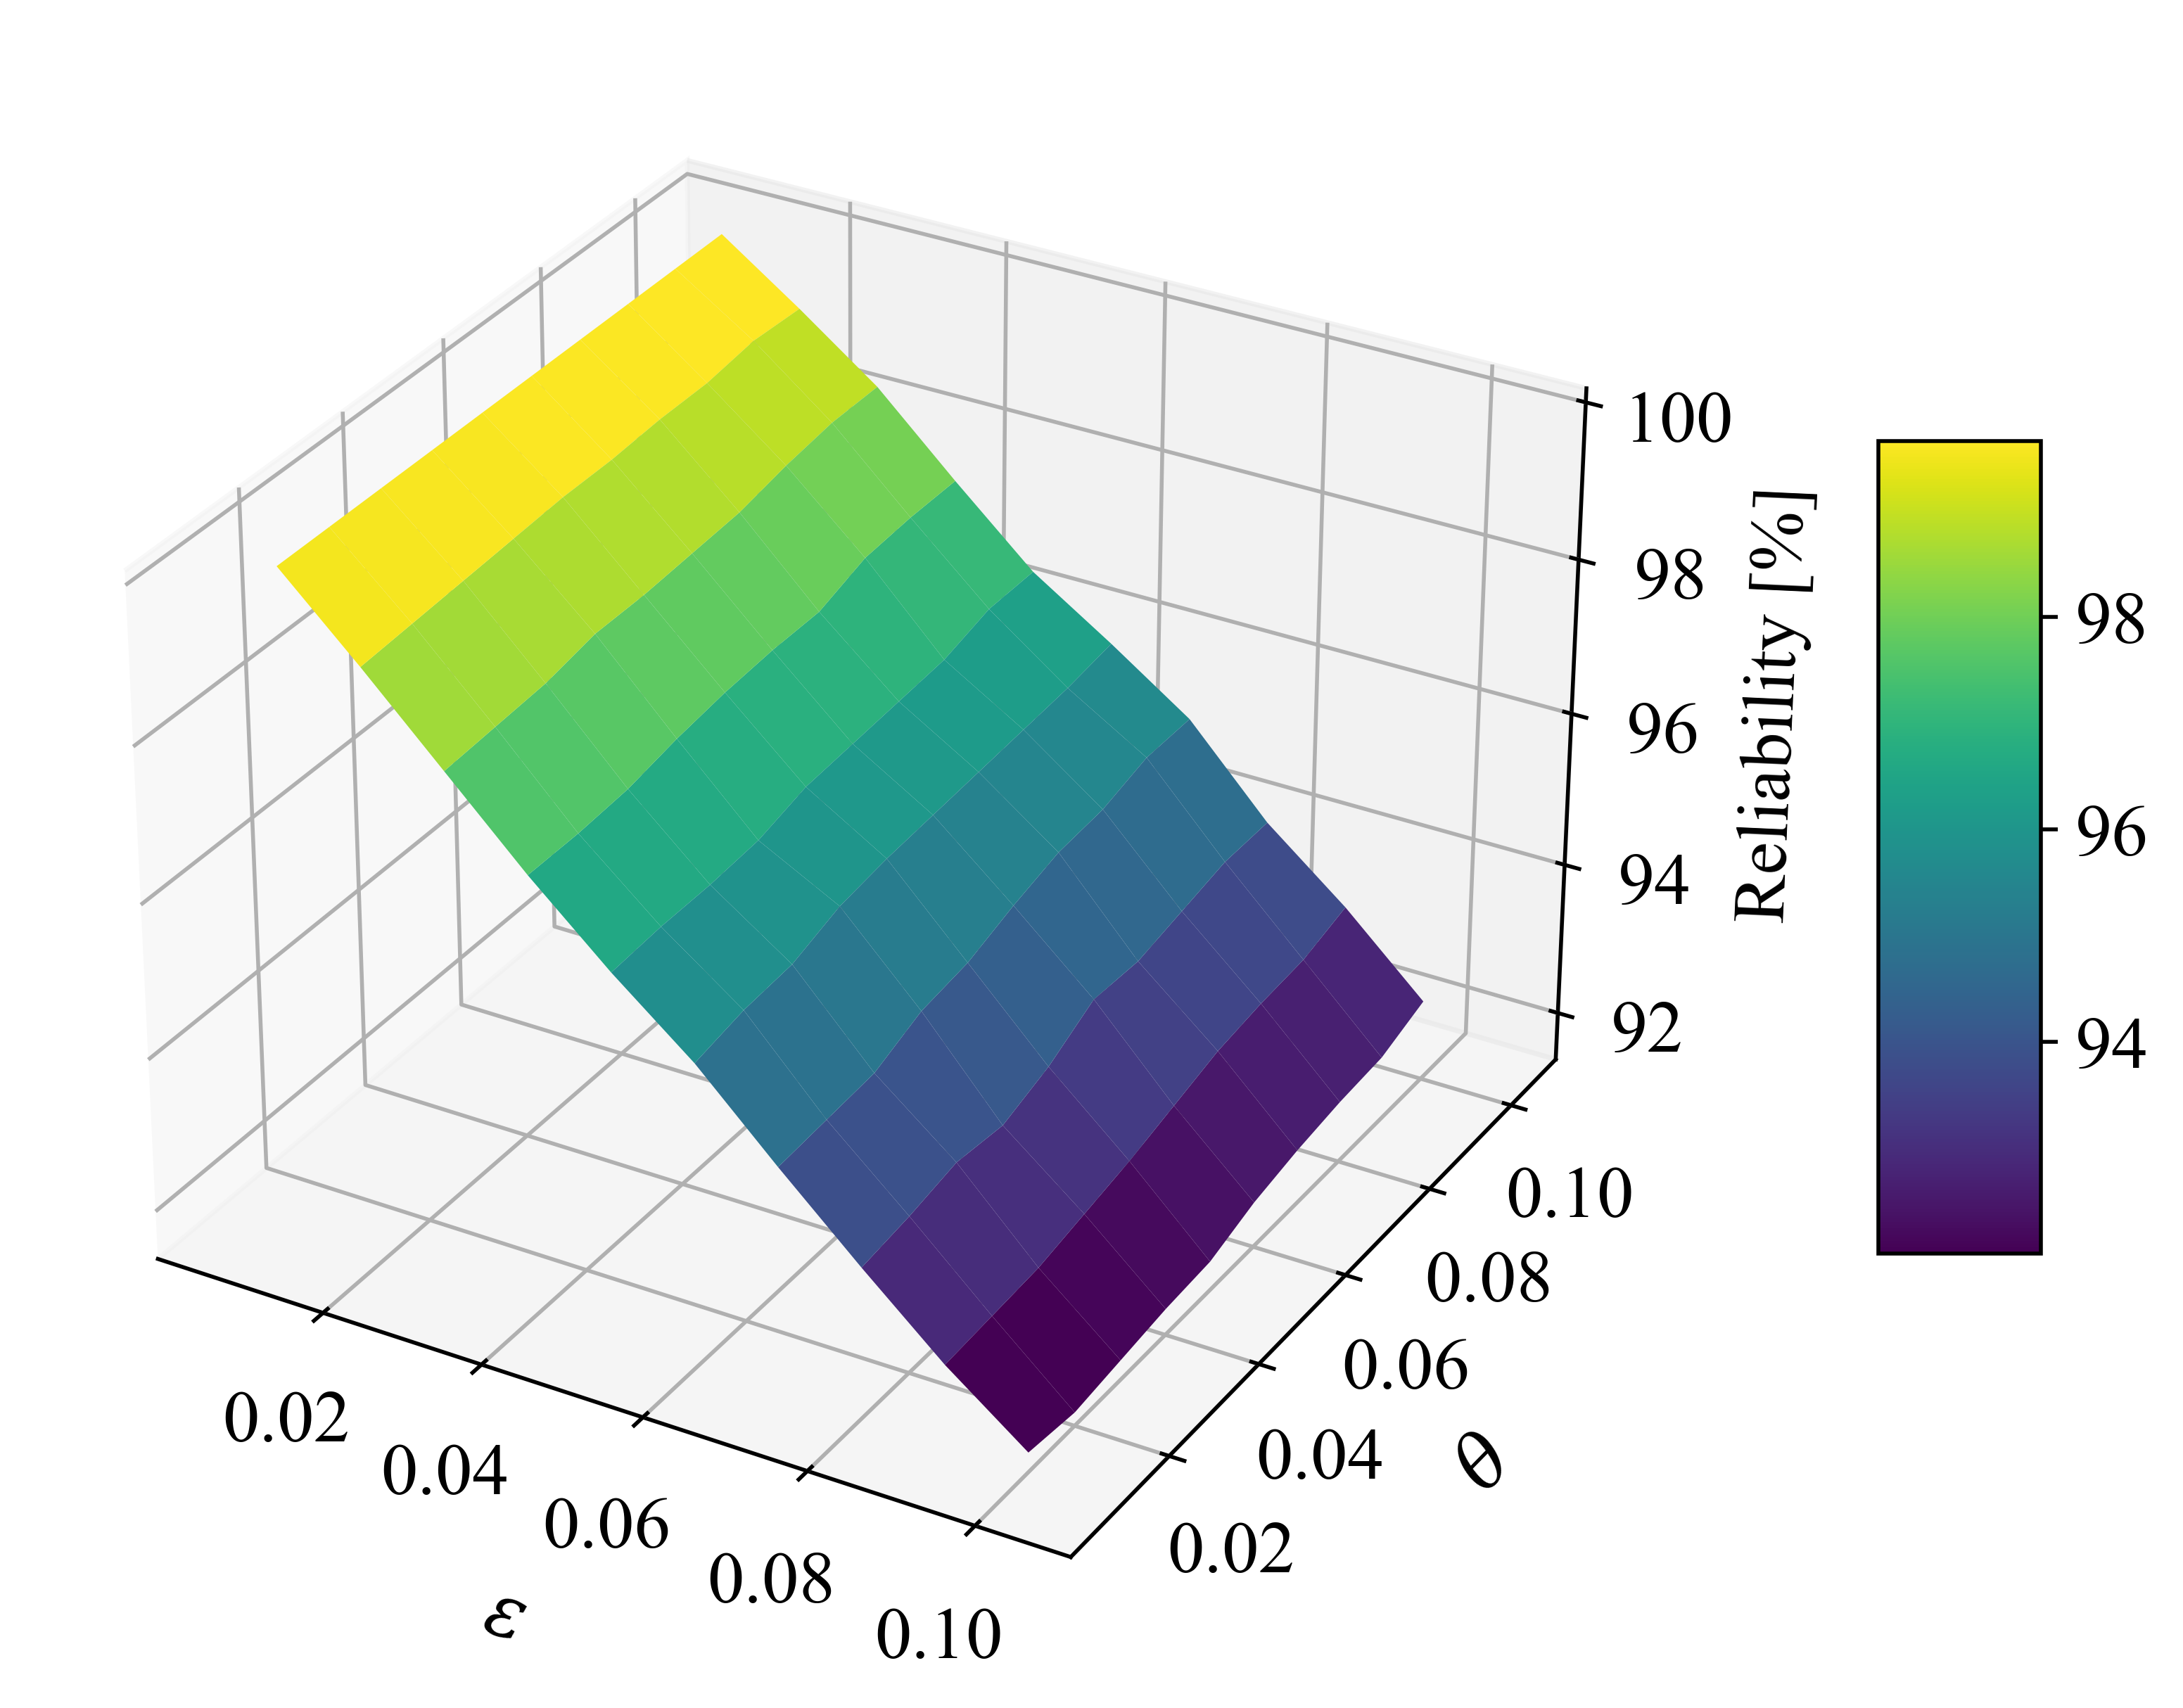

In [28]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.

# Create a sample dataframe
data = all_reliable  # 10x10 matrix as seen in the image
data = np.array(data).transpose()

x_label = r'$ \epsilon$'
y_label = r'$\theta$'
z_label = 'Reliability [%]'
title = r"Reliability $(1-\rho) \times 100$ [%] via $\theta$, $\epsillon$"
file_name = 'reliability'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
case_fig.make_3d_plot(data, label_name, save_flag = True)

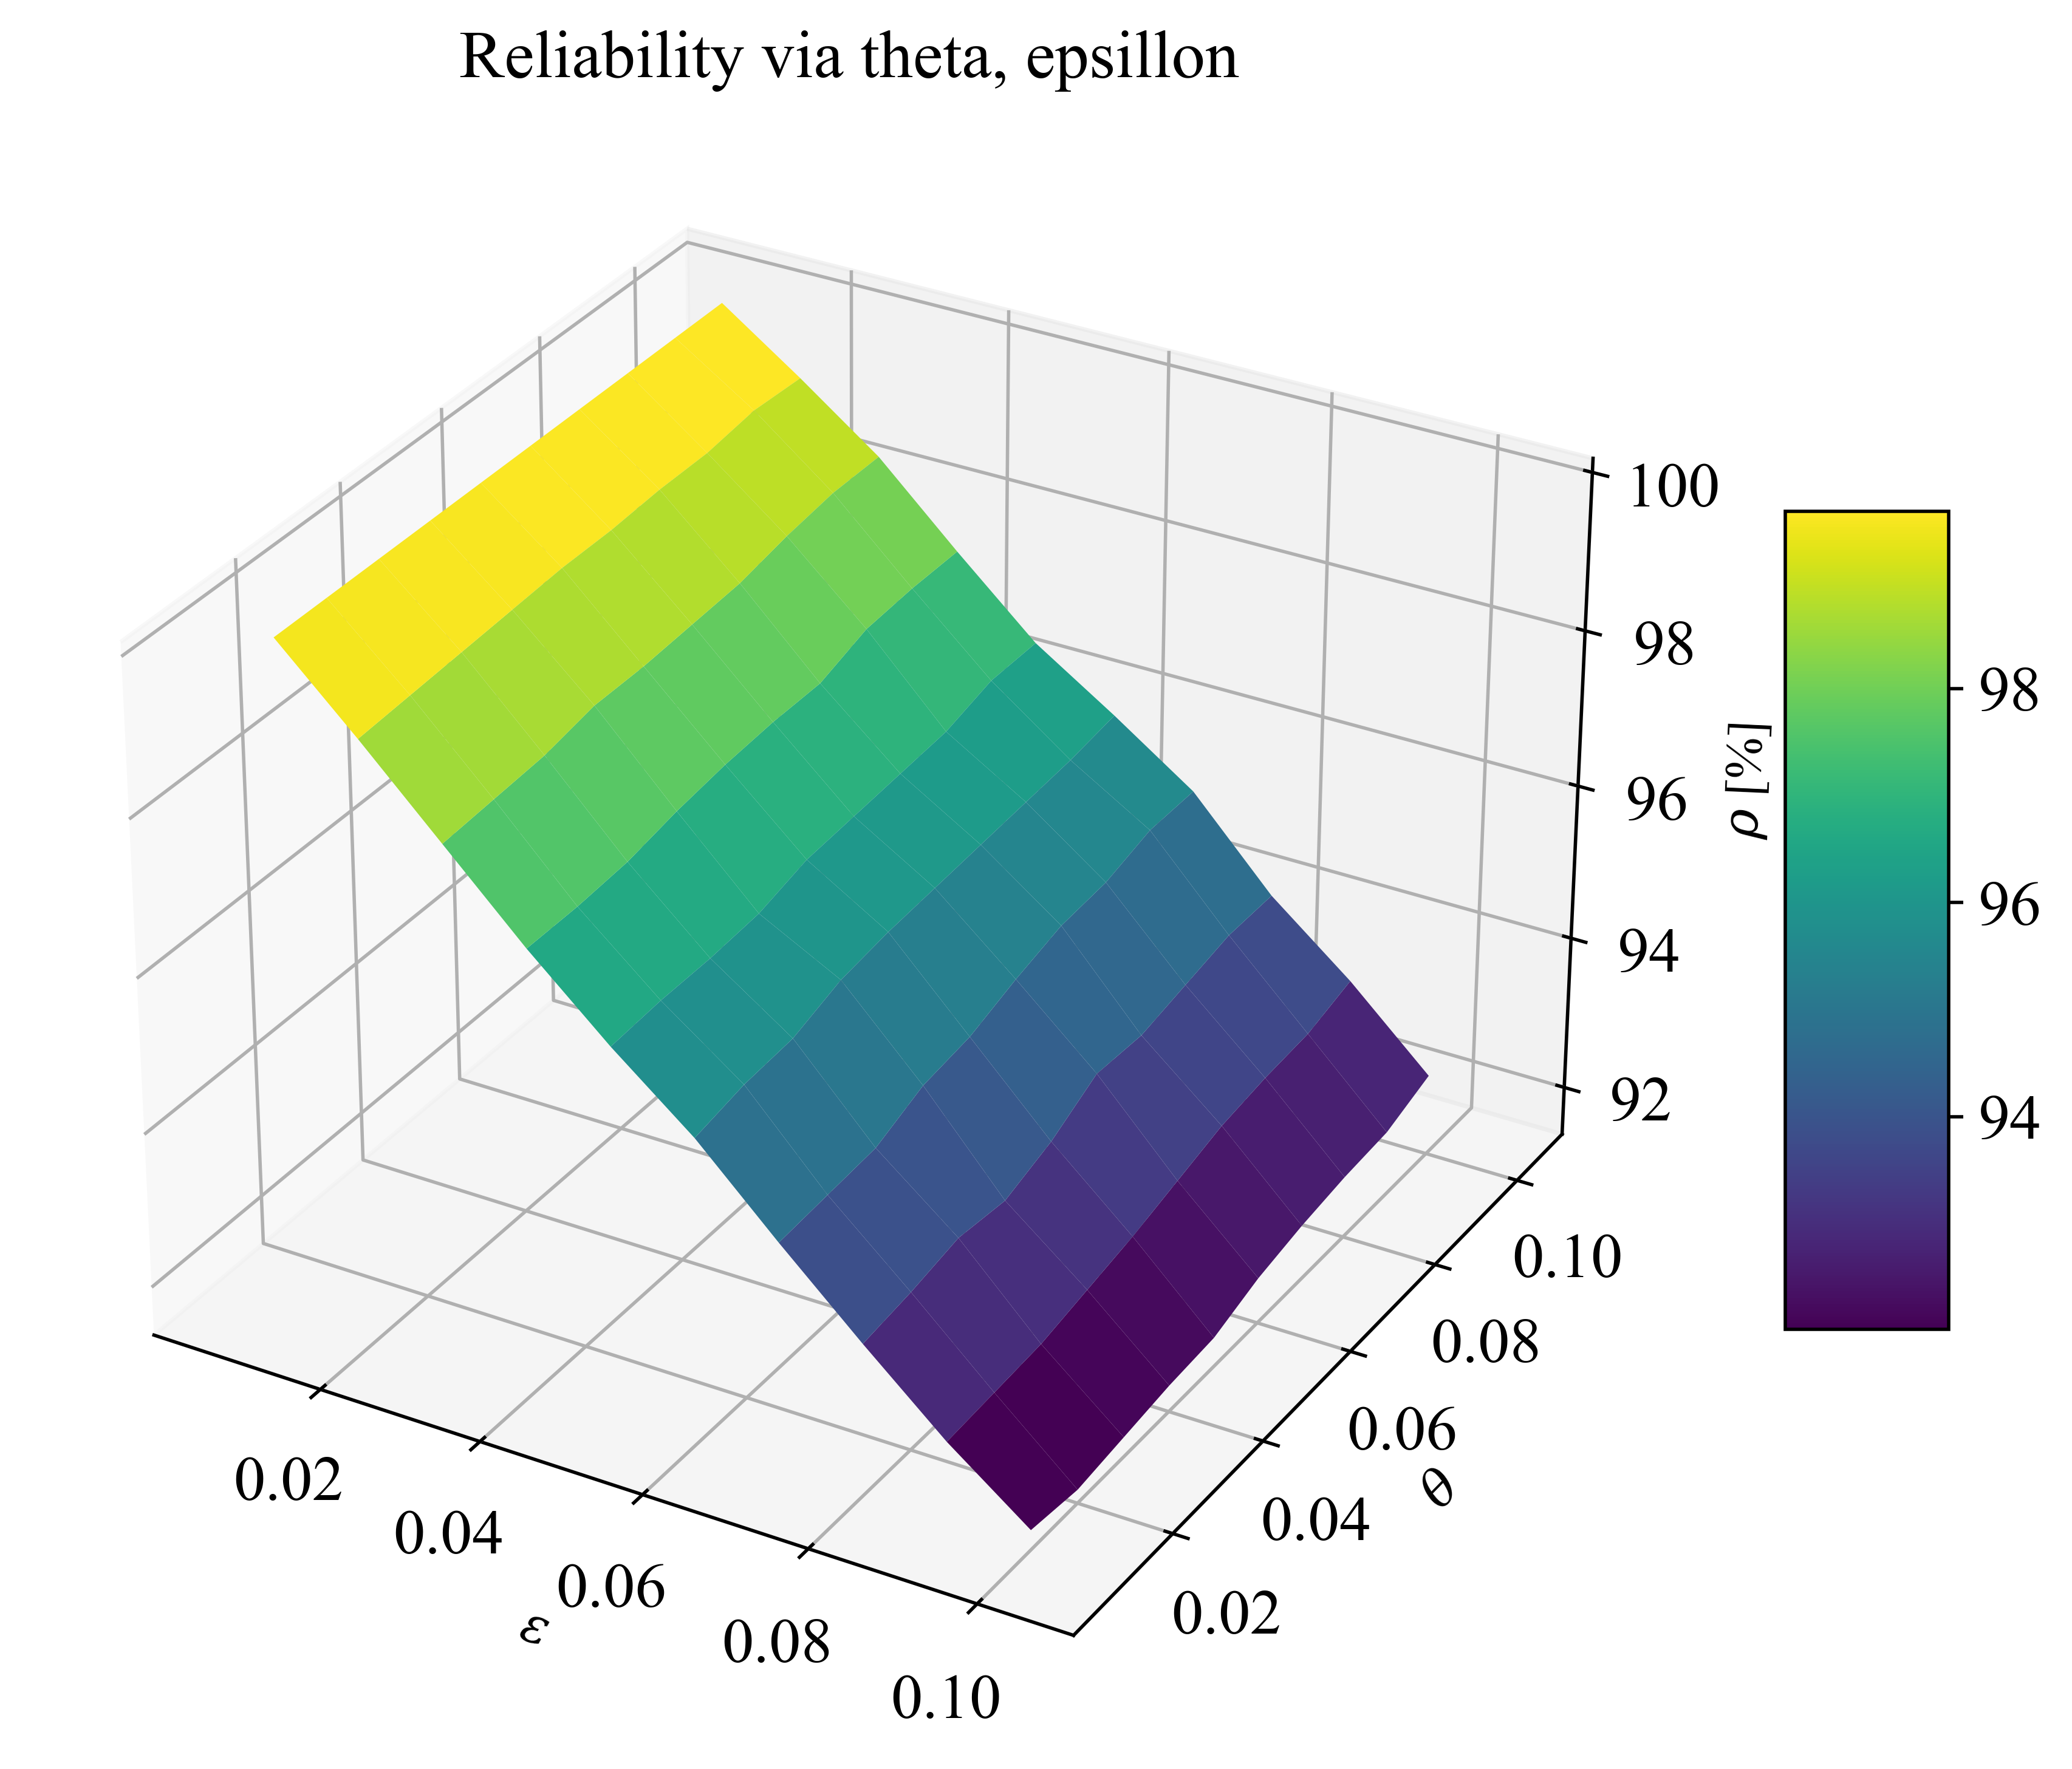

In [29]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.

# Create a sample dataframe
data = all_reliable  # 10x10 matrix as seen in the image
data = np.array(data).transpose()
df = pd.DataFrame(data)

# Initialize a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create coordinate arrays for the dataframe values
X = np.arange(df.shape[1])*0.01 + 0.01
Y = np.arange(df.shape[0])*0.01 + 0.01
X, Y = np.meshgrid(X, Y)
Z = df.values

# Plotting the 3D surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

# Set labels
ax.set_ylabel(r'$\theta$', fontsize=12)
ax.set_xlabel(r'$ \epsilon$', fontsize=12)
ax.set_zlabel(r'$\rho $ [%]', fontsize=12)
ax.set_title("Reliability via theta, epsillon", fontsize=16)

# Show the plot
plt.show()

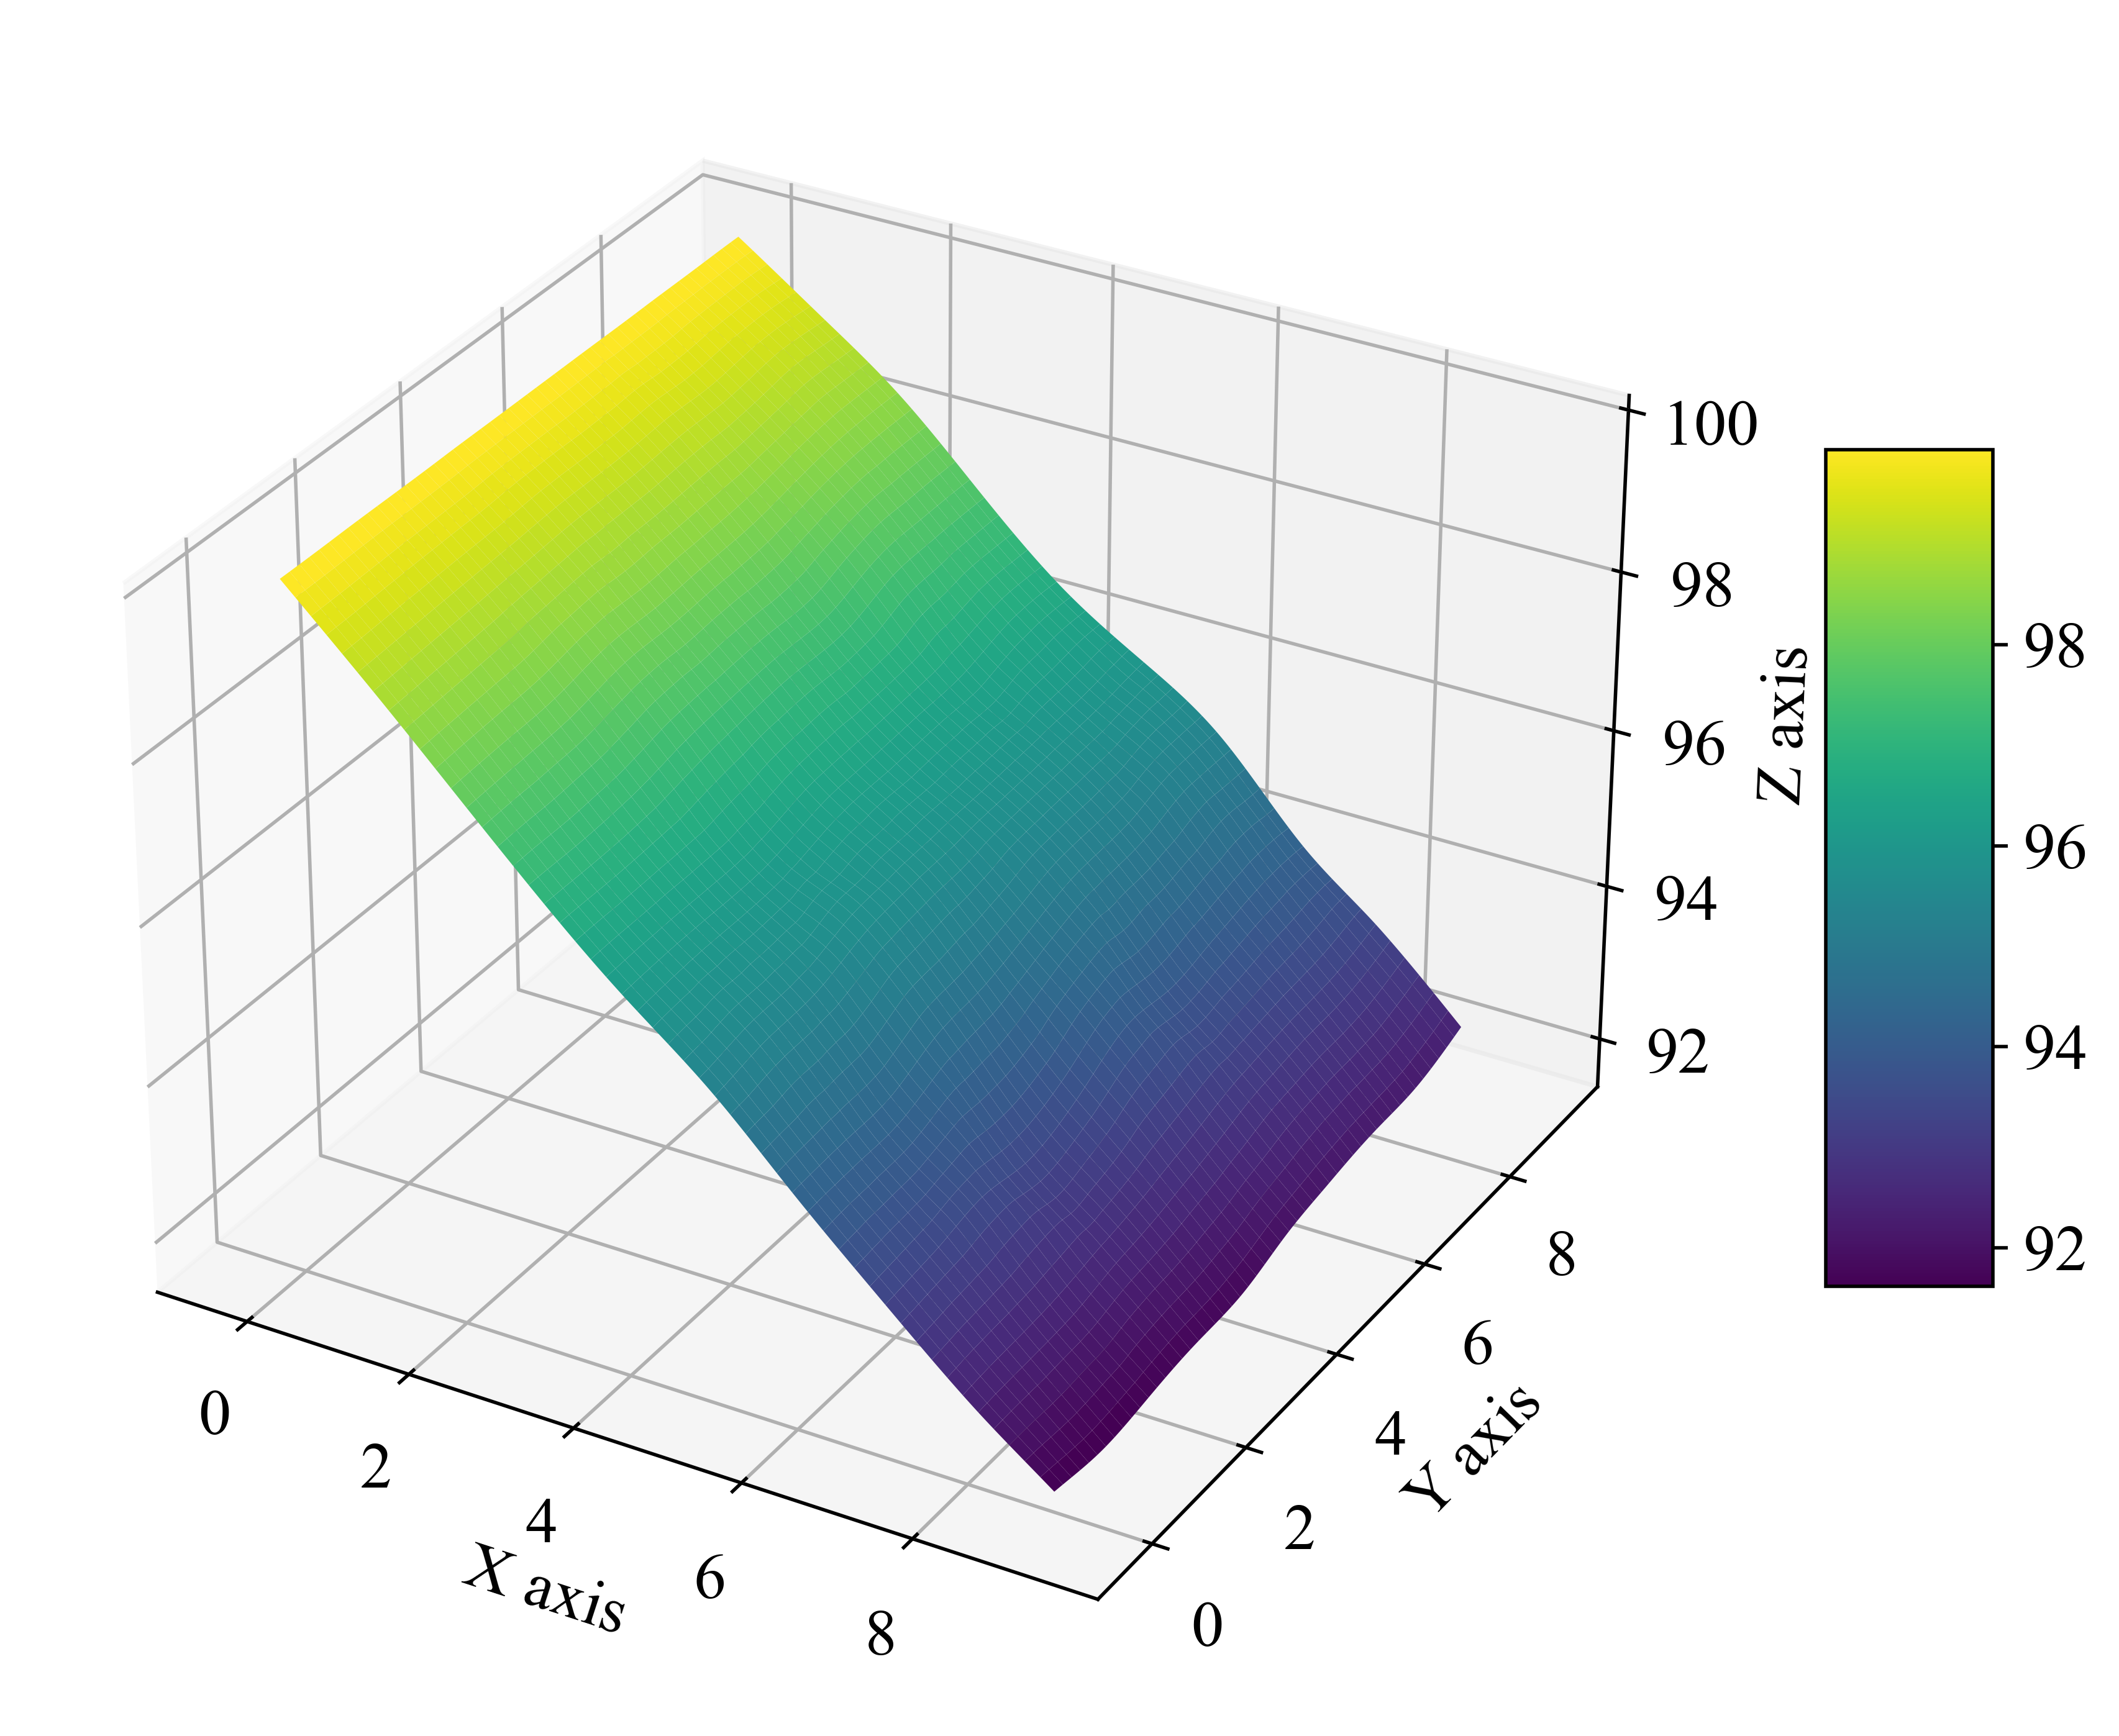

In [30]:
# To make the surface plot smoother, we can interpolate the data
# to create a finer grid before plotting.

from scipy.interpolate import griddata

# Create a dataframe again
data = all_reliable  # 10x10 matrix as seen in the image
data = np.array(data).transpose()
df = pd.DataFrame(data)

# Create the grid coordinates for interpolation
X = np.arange(df.shape[1])
Y = np.arange(df.shape[0])
X, Y = np.meshgrid(X, Y)
Z = df.values.flatten()

# Interpolation grid
xi = np.linspace(X.min(), X.max(), 500)
yi = np.linspace(Y.min(), Y.max(), 500)
xi, yi = np.meshgrid(xi, yi)

# Interpolate; this creates a smooth surface
Zi = griddata((X.flatten(), Y.flatten()), Z, (xi, yi), method='cubic')

# Plotting the smooth surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xi, yi, Zi, cmap='viridis', edgecolor='none')

# Color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()

In [31]:
total_solution_time

1156.4457683563232